# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Multivariado para a Previsão de 2021 

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Multivariada da Série de Arrecadação do ICMS Paulista 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [5]:
df_main_orig.tail(20)

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
220,2021-05-01,1.414623e+10,1069.289,5.291057,137.69,21,1069.289000,5.291057,137.690000,954.262926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,2021-06-01,1.465265e+10,1075.733,5.031905,137.91,21,1075.733000,5.031905,137.910000,956.744009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,2021-07-01,1.570838e+10,1084.095,5.156705,143.07,22,1084.095000,5.156705,143.070000,958.944520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,2021-08-01,1.597532e+10,1091.290,5.251718,141.97,22,1091.290000,5.251718,141.970000,961.725459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2021-09-01,1.622460e+10,1084.312,5.279690,138.79,21,1084.312000,5.279690,138.790000,965.668534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2021-10-01,1.664068e+10,1091.283,5.539980,138.02,20,1091.283000,5.539980,138.020000,970.014042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,2021-11-01,1.737603e+10,1091.483,5.556860,139.75,20,1091.483000,5.556860,139.750000,973.894098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,2021-12-01,1.853772e+10,1100.988,5.651391,141.61,23,1100.988000,5.651391,141.610000,977.984454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,2022-01-01,1.675250e+10,1120.999,5.534105,131.55,21,1107.263632,5.566200,134.311323,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,2022-02-01,1.582980e+10,1141.546,5.196579,136.57,20,1111.692686,5.550000,135.771385,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as últimas linhas que são todas NaN

In [7]:
df_main = df_main_orig.iloc[0:228]
datas = df_main['date']

In [8]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
223,2021-08-01,1.597532e+10,1091.290,5.251718,141.97,22,1091.290,5.251718,141.97,961.725459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2021-09-01,1.622460e+10,1084.312,5.279690,138.79,21,1084.312,5.279690,138.79,965.668534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2021-10-01,1.664068e+10,1091.283,5.539980,138.02,20,1091.283,5.539980,138.02,970.014042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,2021-11-01,1.737603e+10,1091.483,5.556860,139.75,20,1091.483,5.556860,139.75,973.894098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,2021-12-01,1.853772e+10,1100.988,5.651391,141.61,23,1100.988,5.651391,141.61,977.984454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criação das Séries
Como os valores do ICMS são muito elevados a série será colocada em log.

In [9]:
icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)
ibcbr_ts = pd.Series(list(df_main['ibc_br']), index = datas)
igpm_ts = pd.Series(list(df_main['igp_m']), index = datas)
dolar_ts = pd.Series(list(df_main['dolar']), index = datas)
dias_uteis_ts = pd.Series(list(df_main['dias_uteis']), index = datas)
igpm_prev_ts = pd.Series(list(df_main['igp_m_21']), index = datas)
ibcbr_prev_ts = pd.Series(list(df_main['ibc_br_21']), index = datas)
dolar_prev_ts = pd.Series(list(df_main['dolar_21']), index = datas)

#### Testes de Valores Nulos

In [10]:
print('ICMS', icms_ts.isnull().sum())
print('IBC-Br', ibcbr_ts.isnull().sum())
print('IGP-DI', igpm_ts.isnull().sum())
print('Dólar', dolar_ts.isnull().sum())
print('Dias Úteis', dias_uteis_ts.isnull().sum())
print('IGP-M Previsão', igpm_prev_ts.isnull().sum())
print('IBC-Br Previsão', ibcbr_prev_ts.isnull().sum())
print('Dólar Previsão', dolar_prev_ts.isnull().sum())

ICMS 0
IBC-Br 0
IGP-DI 0
Dólar 0
Dias Úteis 0
IGP-M Previsão 0
IBC-Br Previsão 0
Dólar Previsão 0


### Plotando a Série em Nível

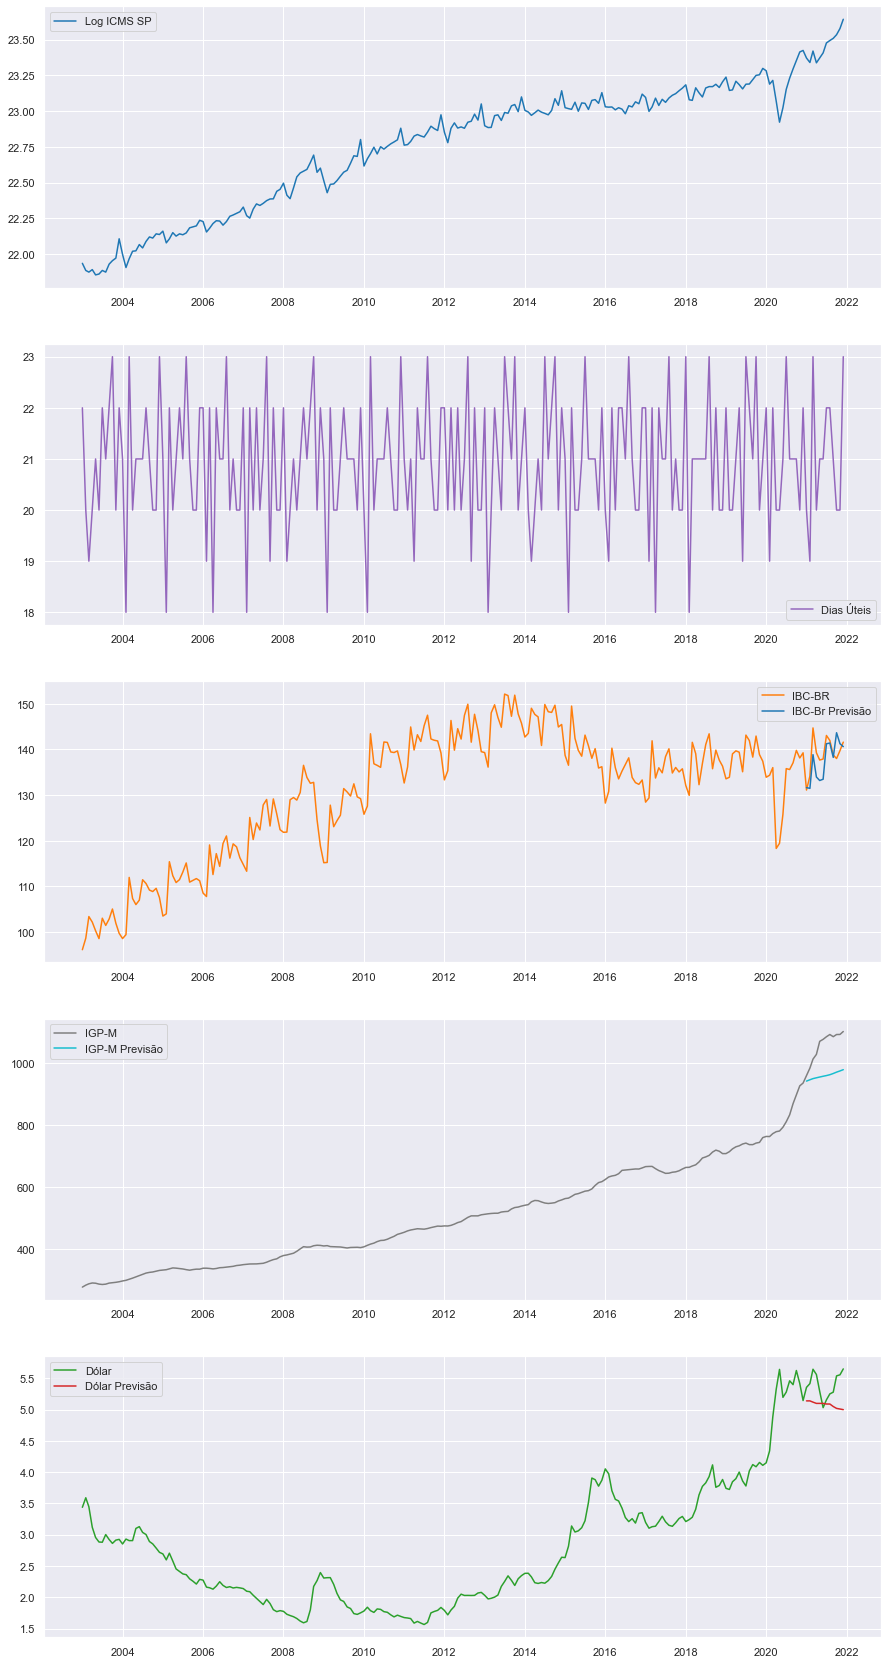

In [11]:
fig=plt.figure(figsize=(15, 30))
ax1=fig.add_subplot(511)
ax2=fig.add_subplot(512)
ax3=fig.add_subplot(513)
ax4=fig.add_subplot(514)
ax5=fig.add_subplot(515)
#plots
ax1.plot(icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts, 'tab:orange',  label='IBC-BR')
ax3.legend(loc='best')
ax3.plot(ibcbr_prev_ts[-12:], 'tab:blue', label='IBC-Br Previsão')
ax3.legend(loc='best')
ax4.plot(igpm_ts, 'tab:gray', label='IGP-M')
ax4.legend(loc='best')
ax4.plot(igpm_prev_ts[-12:], 'tab:cyan',  label='IGP-M Previsão')
ax4.legend(loc='best')
ax5.plot(dolar_ts, 'tab:green', label='Dólar')
ax5.legend(loc='best')
ax5.plot(dolar_prev_ts[-12:], 'tab:red', label='Dólar Previsão')
ax5.legend(loc='best')
plt.show()

### Séries em Primeira Diferença

In [12]:
icms_ts_d1 = icms_ts.diff().dropna()
ibcbr_ts_d1 = ibcbr_ts.diff().dropna()
igpm_ts_d1 = igpm_ts.diff().dropna()
dolar_ts_d1 = dolar_ts.diff().dropna()
dias_uteis_ts_d1 = dias_uteis_ts.diff().dropna()
igpm_prev_ts_d1 = igpm_prev_ts.diff().dropna()
ibcbr_prev_ts_d1 = ibcbr_prev_ts.diff().dropna()
dolar_prev_ts_d1 = dolar_prev_ts.diff().dropna()

### Séries em Segunda Diferença

In [13]:
icms_ts_d2 = icms_ts_d1.diff().dropna()
ibcbr_ts_d2 = ibcbr_ts_d1.diff().dropna()
igpm_ts_d2 = igpm_ts_d1.diff().dropna()
dolar_ts_d2 = dolar_ts_d1.diff().dropna()
dias_uteis_ts_d2 = dias_uteis_ts_d1.diff().dropna()
igpm_prev_ts_d2 = igpm_prev_ts_d1.diff().dropna()
ibcbr_prev_ts_d2 = ibcbr_prev_ts_d1.diff().dropna()
dolar_prev_ts_d2 = dolar_prev_ts_d1.diff().dropna()

### Plotando as Séries em Primeira Diferença

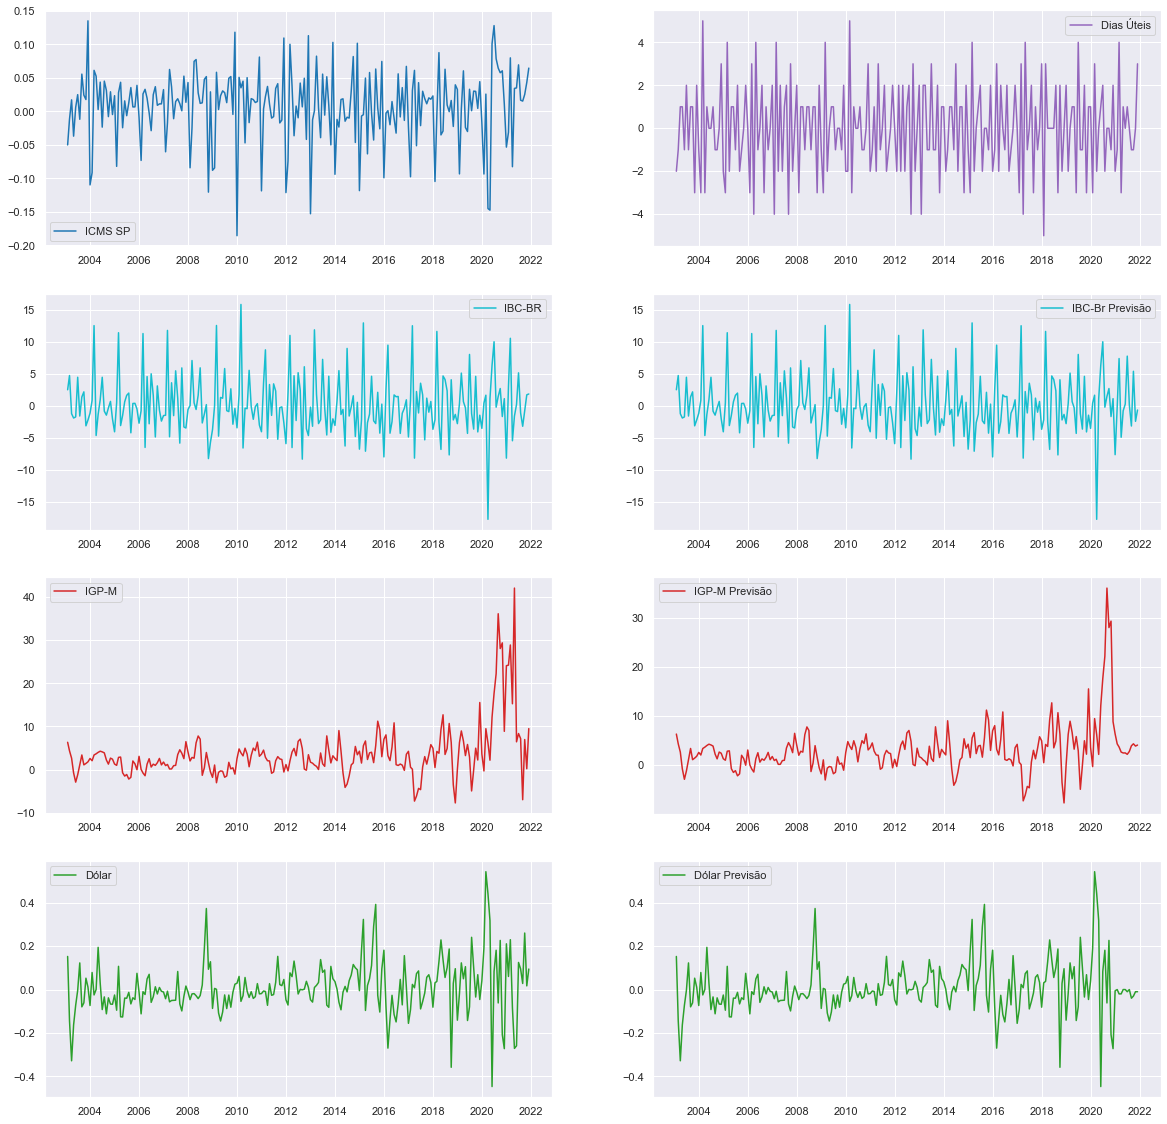

In [14]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d1, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d1, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d1, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d1, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d1, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d1, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d1, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

### Plotando as Séries em Segunda Diferença

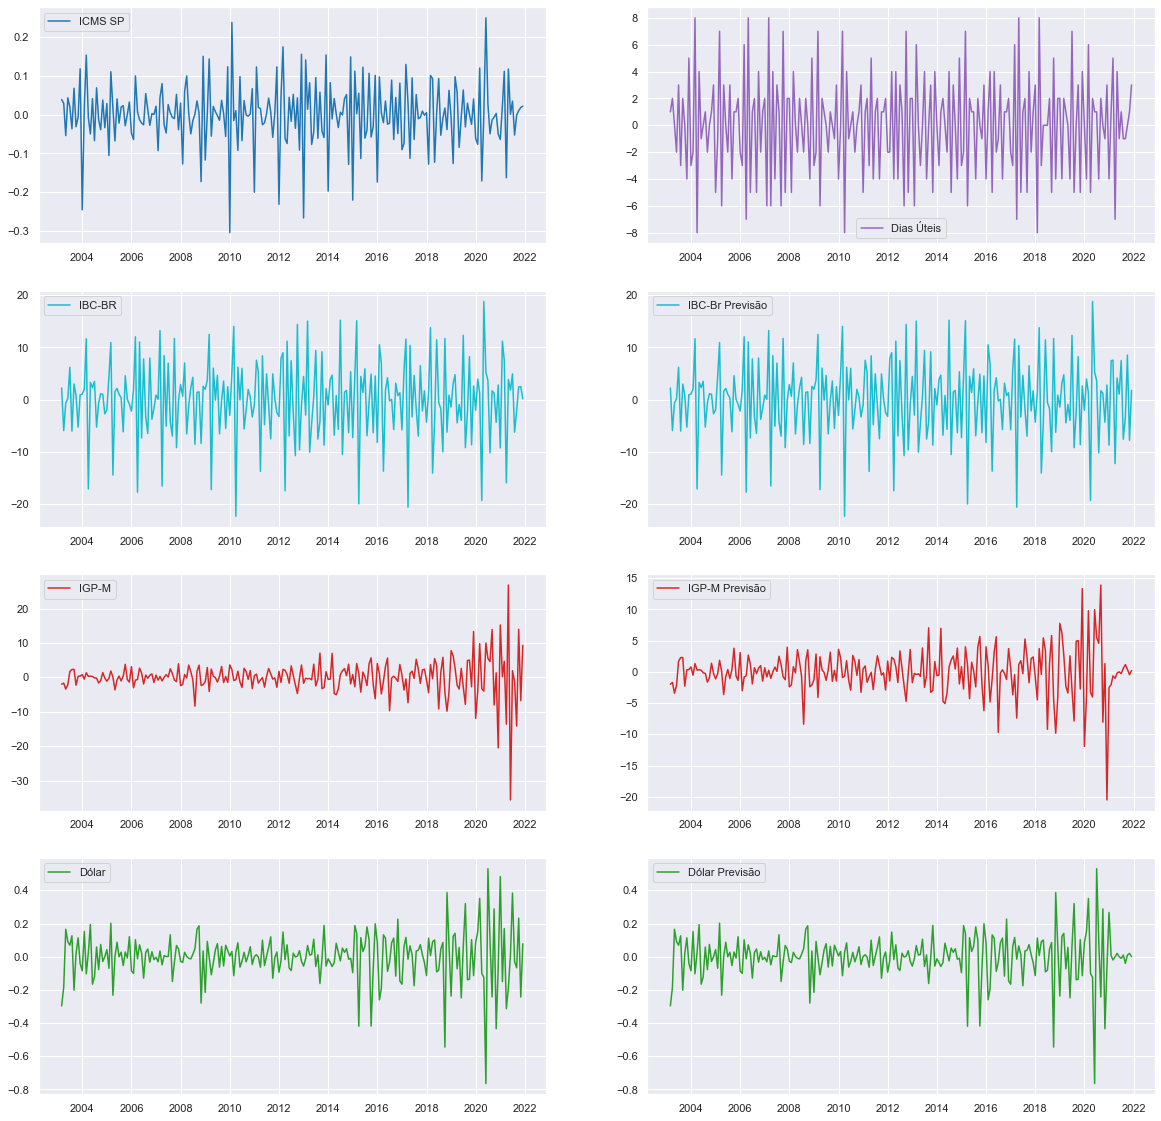

In [15]:
fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(421)
ax2=fig.add_subplot(422)
ax3=fig.add_subplot(423)
ax4=fig.add_subplot(424)
ax5=fig.add_subplot(425)
ax6=fig.add_subplot(426)
ax7=fig.add_subplot(427)
ax8=fig.add_subplot(428)
#plots
ax1.plot(icms_ts_d2, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts_d2, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts_d2, 'tab:cyan',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(ibcbr_prev_ts_d2, 'tab:cyan', label='IBC-Br Previsão')
ax4.legend(loc='best')
ax5.plot(igpm_ts_d2, 'tab:red', label='IGP-M')
ax5.legend(loc='best')
ax6.plot(igpm_prev_ts_d2, 'tab:red',  label='IGP-M Previsão')
ax6.legend(loc='best')
ax7.plot(dolar_ts_d2, 'tab:green', label='Dólar')
ax7.legend(loc='best')
ax8.plot(dolar_prev_ts_d2, 'tab:green', label='Dólar Previsão')
ax8.legend(loc='best')
plt.show()

### Teste de Raiz Unitária das Séries em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#### Série do ICMS

In [17]:
adf_test(icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.890864
p-value                          0.790966
#Lags Used                      12.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [18]:
kpss_test(icms_ts)

Results of KPSS Test:
Test Statistic           2.275043
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IBC-Br

In [19]:
adf_test(ibcbr_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.313601
p-value                          0.167619
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


In [20]:
kpss_test(ibcbr_ts)

Results of KPSS Test:
Test Statistic           1.558092
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IBC-Br em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do IGP-M

In [21]:
adf_test(igpm_ts)

Results of Dickey-Fuller Test:
Test Statistic                   2.771061
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [22]:
kpss_test(igpm_ts)

Results of KPSS Test:
Test Statistic           2.175952
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em nível: a 5%, não se rejeita a nula do teste ADF e rejeita-se a nula do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série do Dólar

In [23]:
adf_test(dolar_ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.925920
p-value                          0.993419
#Lags Used                      14.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


In [24]:
kpss_test(dolar_ts)

Results of KPSS Test:
Test Statistic           1.414523
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em nível: a 5%, não se rejeita a nula do teste ADF e rejeita-se a nula do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

#### Série Dias Úteis

In [25]:
adf_test(dias_uteis_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -4.141222
p-value                          0.000827
#Lags Used                      14.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


In [26]:
kpss_test(dias_uteis_ts)

Results of KPSS Test:
Test Statistic           0.086253
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série dos Dias Úteis em nível: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em nível.

### Teste de Raiz Unitária da Série em Primeira Diferença
As séries postas em primeira diferença serão testadas para estacionariedade com os testes ADF e KPSS.

#### Série do ICMS

In [27]:
adf_test(icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.321049
p-value                          0.000408
#Lags Used                      11.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [28]:
kpss_test(icms_ts_d1)

Results of KPSS Test:
Test Statistic           0.07321
p-value                  0.10000
Lags Used                7.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IBC-Br

In [29]:
adf_test(ibcbr_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.833250
p-value                          0.002585
#Lags Used                      14.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


In [30]:
kpss_test(ibcbr_ts_d1)

Results of KPSS Test:
Test Statistic            0.310779
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do IBC-Br em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

#### Série do IGP-M

In [31]:
adf_test(igpm_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.961588
p-value                          0.001626
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [32]:
kpss_test(igpm_ts_d1)

Results of KPSS Test:
Test Statistic           0.672704
p-value                  0.016027
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do IGP-M em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [33]:
adf_test(igpm_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                -5.801737e+00
p-value                        4.614048e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [34]:
kpss_test(igpm_ts_d2)

Results of KPSS Test:
Test Statistic            0.04583
p-value                   0.10000
Lags Used                13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


Série do IGP-M em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série do Dólar

In [35]:
adf_test(dolar_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.549544
p-value                          0.000002
#Lags Used                       4.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [36]:
kpss_test(dolar_ts_d1)

Results of KPSS Test:
Test Statistic           0.762196
p-value                  0.010000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do Dólar em primeira diferença: a 5%, rejeita-se a nula do teste ADF e também se rejeita a nula do teste KPSS. A série é estacionária pelo teste ADF mas não é estacionária pelo teste KPSS. A série precisa ser diferenciada novamente para poder ser usada.

##### Diferenciando novamente a série e testando a estacionariedade

In [37]:
dolar_ts_d2 = dolar_ts_d1.diff().dropna()

In [38]:
adf_test(dolar_ts_d2)

Results of Dickey-Fuller Test:
Test Statistic                -6.443290e+00
p-value                        1.588477e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


In [39]:
kpss_test(dolar_ts_d2)

Results of KPSS Test:
Test Statistic            0.132405
p-value                   0.100000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do Dólar em segunda diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em segunda diferença.

#### Série Dias Úteis

Não será testada, pois já é estacionária em nível.

### Estacionariedade das Séries

Conclue-se que, para se trabalhar com todas as séries estacionárias, as séries serão usadas em nível, em primeira ou segunda diferença, conforme abaixo:
- ICMS: primeira diferença
- IBC-Br: primeira diferença
- IGP-M: segunda diferença
- Dólar: segunda diferença
- Dias Úteis: nível

##### Equalizando o tamanho das séries
IPCA e Dias Úteis ficaram maiores que as demais séries estão em nível, assim como as séries em primeira diferenças estão maiores do que as em segunda diferença. O primeiro e o segundo valores destas duas séries, e somente o primeiro das que estão em primeira diferança serão removidos.

In [40]:
print('antes', icms_ts_d1.shape, ibcbr_ts_d1.shape, igpm_ts_d2.shape, dolar_ts_d2.shape, dias_uteis_ts.shape,
     ibcbr_prev_ts_d1.shape, igpm_prev_ts_d2.shape, dolar_prev_ts_d2.shape,)
icms_ts_adj = icms_ts_d1[1:]
ibcbr_ts_adj = ibcbr_ts_d1[1:]
igpm_ts_adj = igpm_ts_d2
dolar_ts_adj = dolar_ts_d2
dias_uteis_ts_adj = dias_uteis_ts[2:]
ibcbr_prev_ts_adj = ibcbr_prev_ts_d1[1:]
igpm_prev_ts_adj = igpm_prev_ts_d2
dolar_prev_ts_adj = dolar_prev_ts_d2
print('depois', icms_ts_adj.shape, ibcbr_ts_adj.shape, igpm_ts_adj.shape, dolar_ts_adj.shape, 
      dias_uteis_ts_adj.shape, ibcbr_prev_ts_adj.shape, igpm_prev_ts_adj.shape, dolar_prev_ts_adj.shape)

antes (227,) (227,) (226,) (226,) (228,) (227,) (226,) (226,)
depois (226,) (226,) (226,) (226,) (226,) (226,) (226,) (226,)


### Dessazonalização das Séries

In [41]:
sns.set(rc={'figure.figsize':(15,8)})

#### Série do ICMS

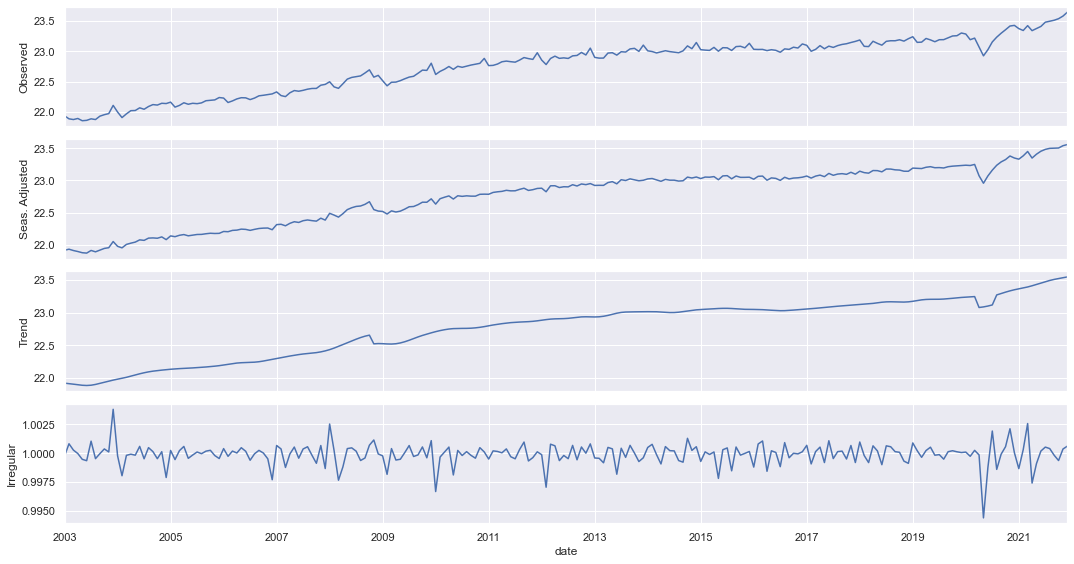

In [42]:
seas_icms = statsmodels.tsa.x13.x13_arima_analysis(icms_ts, x12path='./x13asmac/')
plot = seas_icms.plot()

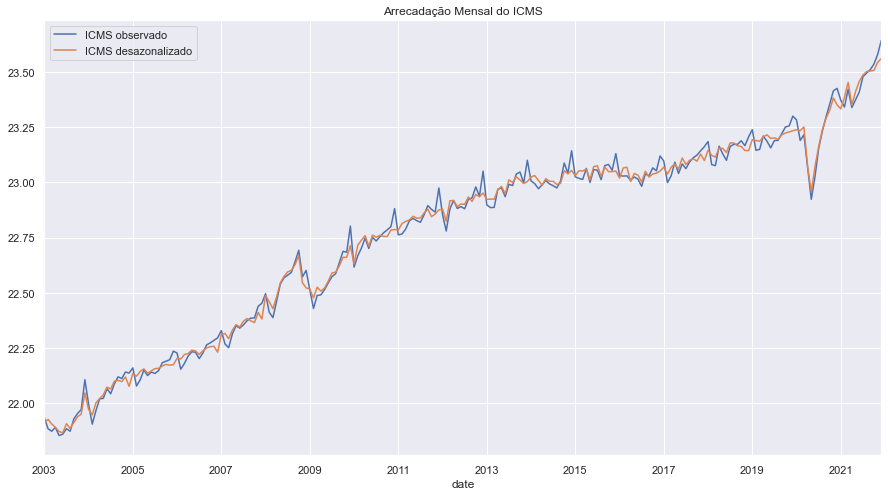

In [43]:
icms_decomp = pd.DataFrame(data={'ICMS observado': seas_icms.observed, 
                                 'ICMS desazonalizado': seas_icms.seasadj})
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

#### Série do IBC-Br

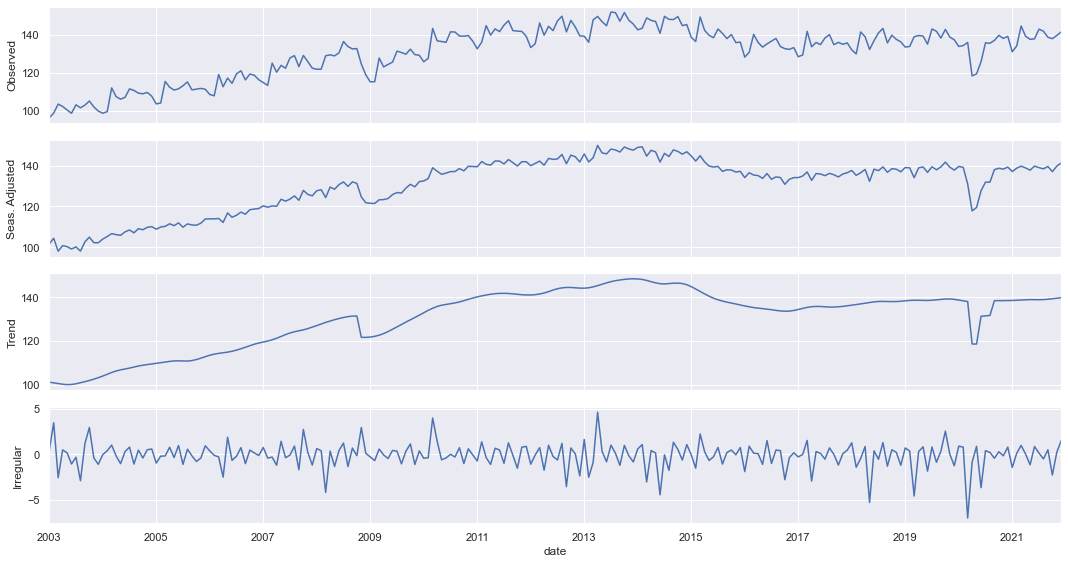

In [44]:
sns.set(rc={'figure.figsize':(15,8)})
seas_ibcbr = statsmodels.tsa.x13.x13_arima_analysis(ibcbr_ts, x12path='./x13asmac/')
plot = seas_ibcbr.plot()

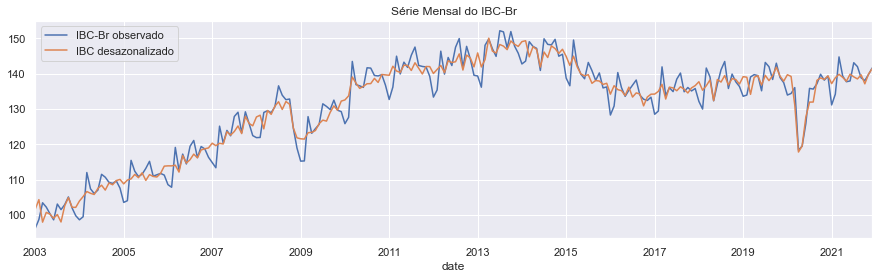

In [45]:
sns.set(rc={'figure.figsize':(15,4)})
ibcbr_decomp = pd.DataFrame(data={'IBC-Br observado': seas_ibcbr.observed, 
                                  'IBC desazonalizado': seas_ibcbr.seasadj})
plot = ibcbr_decomp.plot(title='Série Mensal do IBC-Br')

#### Série do IGP-DI

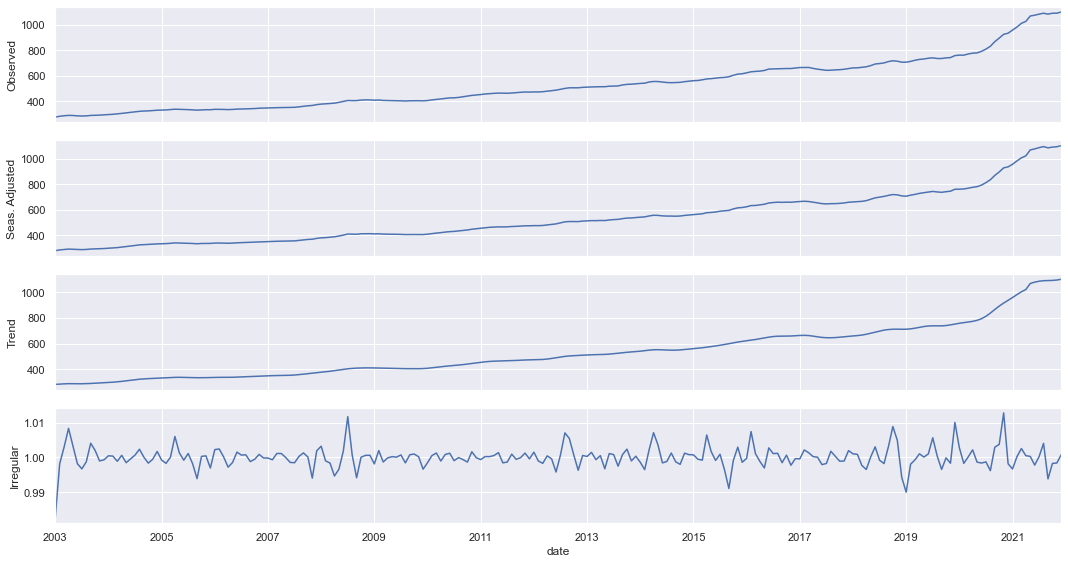

In [46]:
sns.set(rc={'figure.figsize':(15,8)})
seas_igpm = statsmodels.tsa.x13.x13_arima_analysis(igpm_ts, x12path='./x13asmac/')
plot = seas_igpm.plot()

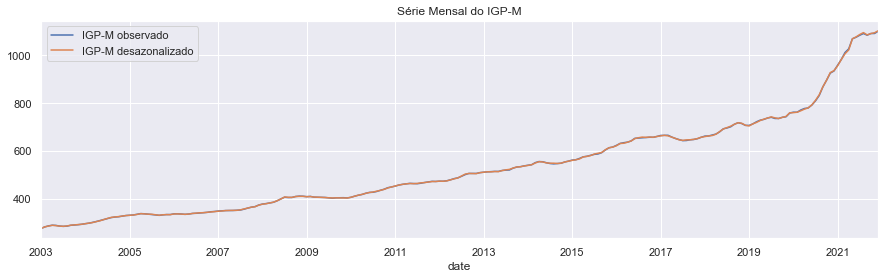

In [47]:
sns.set(rc={'figure.figsize':(15,4)})
igpm_decomp = pd.DataFrame(data={'IGP-M observado': seas_igpm.observed, 
                                  'IGP-M desazonalizado': seas_igpm.seasadj})
plot = igpm_decomp.plot(title='Série Mensal do IGP-M')

#### Série do Dólar

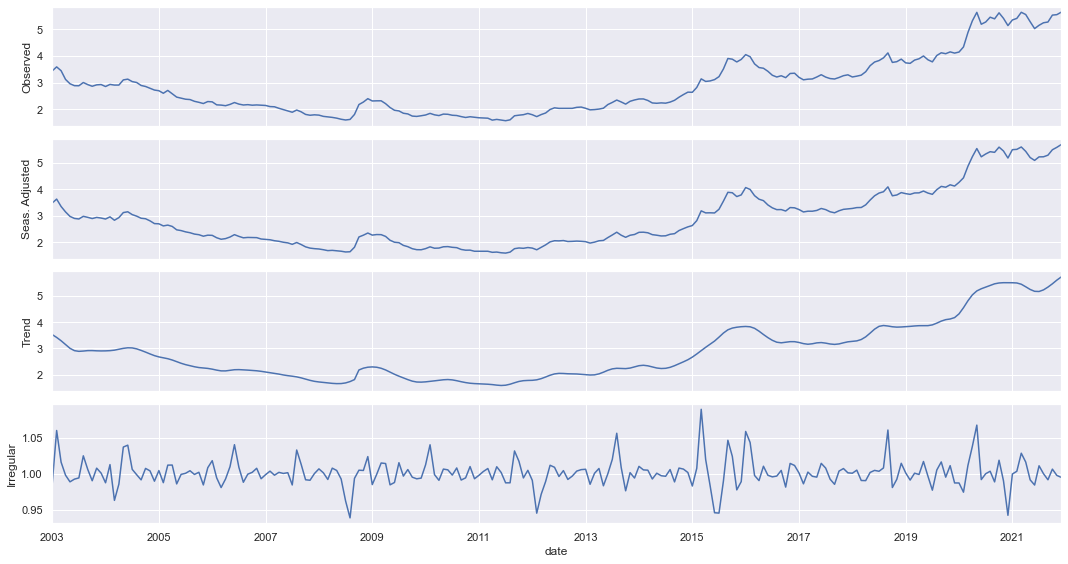

In [48]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dolar = statsmodels.tsa.x13.x13_arima_analysis(dolar_ts, x12path='./x13asmac/')
plot = seas_dolar.plot()

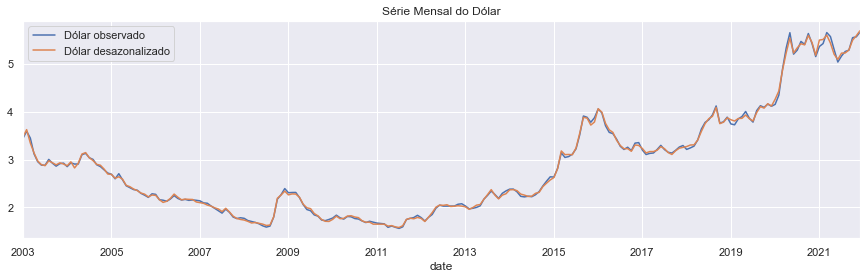

In [49]:
sns.set(rc={'figure.figsize':(15,4)})
dolar_decomp = pd.DataFrame(data={'Dólar observado': seas_dolar.observed, 
                                  'Dólar desazonalizado': seas_dolar.seasadj})
plot = dolar_decomp.plot(title='Série Mensal do Dólar')

#### Série dos Dias Úteis

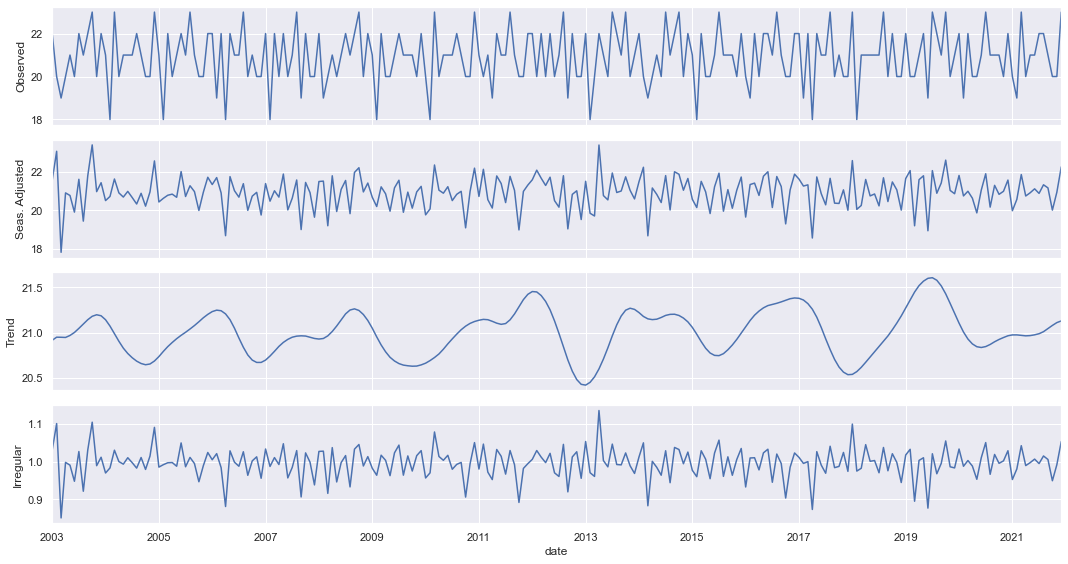

In [50]:
sns.set(rc={'figure.figsize':(15,8)})
seas_dias_uteis = statsmodels.tsa.x13.x13_arima_analysis(dias_uteis_ts, x12path='./x13asmac/')
plot = seas_dias_uteis.plot()

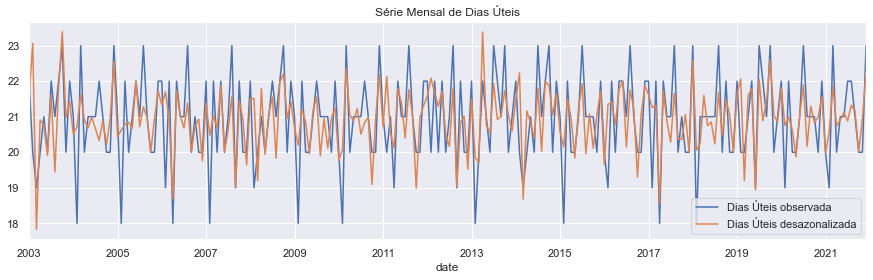

In [51]:
sns.set(rc={'figure.figsize':(15,4)})
dias_uteis_decomp = pd.DataFrame(data={'Dias Úteis observada': seas_dias_uteis.observed, 
                                  'Dias Úteis desazonalizada': seas_dias_uteis.seasadj})
plot = dias_uteis_decomp.plot(title='Série Mensal de Dias Úteis')

In [52]:
sns.set(rc={'figure.figsize':(15,8)})

### Criando dummies de intervenção

In [53]:
pos = seas_icms.results.find('Outliers')
print(seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   LS2008.Nov                  -0.0063         0.00114        -5.58
   LS2020.Apr                  -0.0075         0.00121        -6.19
   AO2020.May                  -0.0059         0.00125        -4.73
   LS2020.Aug                   0.0057         0.00116         4.96
 ------------------------------------------------------------------------------


 ARIMA Model:  (2 1 0)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nonseasonal AR                                    
   Lag  1            

In [54]:
ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
dt_final = str(ls2008nov.index[-1])

ls2008nov['2008-11-01':dt_final] = 1
ls2020abr = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020abr['2020-04-01':dt_final ] = 1
ao2020mai = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ao2020mai['2020-05-01'] = 1
ls2020ago = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020ago['2020-08-01':dt_final ] = 1

In [55]:
ls2008nov.shape, ls2020abr.shape, ao2020mai.shape, ls2020ago.shape

((228,), (228,), (228,), (228,))

### Testes de Causalidade de Granger
Verificando quais das séries causam ICMS para que possam ser usadas como exógenas nos modelos.

#### Verificando se IBC-Br granger causa ICMS

In [56]:
gt_data = pd.DataFrame({'ibcbr':list(seas_ibcbr.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4948  , p=0.2228  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=1.5148  , p=0.2184  , df=1
likelihood ratio test: chi2=1.5098  , p=0.2192  , df=1
parameter F test:         F=1.4948  , p=0.2228  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2065  , p=0.8136  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=0.4224  , p=0.8096  , df=2
likelihood ratio test: chi2=0.4220  , p=0.8098  , df=2
parameter F test:         F=0.2065  , p=0.8136  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9997  , p=0.3939  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=3.0953  , p=0.3772  , df=3
likelihood ratio test: chi2=3.0742  , p=0.3803  , df=3
parameter F test:         F=0.9997  , p=0.3939  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9174  , p=0.1086  

{1: ({'lrtest': (1.5098008918621417, 0.21916947102018294, 1),
   'params_ftest': (1.494813145365422, 0.22275600695232425, 224.0, 1.0),
   'ssr_chi2test': (1.5148329642763536, 0.2184030974670014, 1),
   'ssr_ftest': (1.4948131453652125, 0.22275600695235856, 224.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.42196975052183916, 0.8097863145953735, 2),
   'params_ftest': (0.20650979786754617, 0.8135750765280982, 221.0, 2.0),
   'ssr_chi2test': (0.4223639304800846, 0.8096267295543589, 2),
   'ssr_ftest': (0.20650979786747498, 0.8135750765281582, 221.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (3.074161316812024, 0.3803316966146002, 3),
   'params_ftest': (0.9996538011581694, 0.393892318389524, 218.0, 3.0),
   'ssr_chi2test': (3.0952583292741527, 0.37717012915705794, 3),
   'ssr_ftest': (0.9996538011581707, 0.393892318389524, 218.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

A 5%, IBC-Br granger causa ICMS no lag 7.

#### Verificando se IGP-M granger causa ICMS

In [57]:
gt_data = pd.DataFrame({'igpm':list(seas_igpm.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1082  , p=0.0028  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=9.2302  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0475  , p=0.0026  , df=1
parameter F test:         F=9.1082  , p=0.0028  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7686  , p=0.4649  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=1.5720  , p=0.4557  , df=2
likelihood ratio test: chi2=1.5666  , p=0.4569  , df=2
parameter F test:         F=0.7686  , p=0.4649  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3646  , p=0.2545  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=4.2251  , p=0.2382  , df=3
likelihood ratio test: chi2=4.1859  , p=0.2421  , df=3
parameter F test:         F=1.3646  , p=0.2545  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9875  , p=0.4153  

{1: ({'lrtest': (9.047455305249969, 0.0026306070549719754, 1),
   'params_ftest': (9.1081906051678, 0.0028391696539051482, 224.0, 1.0),
   'ssr_chi2test': (9.230175300772105, 0.002380588542884412, 1),
   'ssr_ftest': (9.108190605167186, 0.002839169653906095, 224.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1.5665785611556657, 0.4569006624301276, 2),
   'params_ftest': (0.7686207426968399, 0.46488748439548455, 221.0, 2.0),
   'ssr_chi2test': (1.5720207045191685, 0.4556590929420752, 2),
   'ssr_ftest': (0.7686207426963192, 0.4648874843957316, 221.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4.185936970526882, 0.24207363792244416, 3),
   'params_ftest': (1.3645564655747153, 0.2545326512179137, 218.0, 3.0),
   'ssr_chi2test': (4.22511749661823, 0.2381591481056026, 3),
   'ssr_ftest': (1.3645564655744804, 0.25453265121798435, 218.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

A 5%, IGP-DI granger causa ICMS a partir do lag 6.

#### Verificando se Dólar granger causa ICMS

In [58]:
gt_data = pd.DataFrame({'dolar':list(seas_dolar.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4458 , p=0.0003  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=13.6259 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2326 , p=0.0003  , df=1
parameter F test:         F=13.4458 , p=0.0003  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6860  , p=0.0039  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=11.6293 , p=0.0030  , df=2
likelihood ratio test: chi2=11.3400 , p=0.0034  , df=2
parameter F test:         F=5.6860  , p=0.0039  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8274  , p=0.0106  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=11.8510 , p=0.0079  , df=3
likelihood ratio test: chi2=11.5494 , p=0.0091  , df=3
parameter F test:         F=3.8274  , p=0.0106  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4778  , p=0.0089  

{1: ({'lrtest': (13.232571204530814, 0.000275126144867107, 1),
   'params_ftest': (13.445783418885236, 0.0003067503095226882, 224.0, 1.0),
   'ssr_chi2test': (13.625860875388144, 0.00022309116680067646, 1),
   'ssr_ftest': (13.445783418885215, 0.00030675030952269247, 224.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (11.339990045199784, 0.003447882437550834, 2),
   'params_ftest': (5.686013109138481, 0.0039086913471011835, 221.0, 2.0),
   'ssr_chi2test': (11.629311879323668, 0.0029835066572112246, 2),
   'ssr_ftest': (5.686013109138342, 0.003908691347101677, 221.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (11.549449395409852, 0.009097257784134892, 3),
   'params_ftest': (3.8274369015944743, 0.010615187941563705, 218.0, 3.0),
   'ssr_chi2test': (11.851008754938702, 0.007911364513688401, 3),
   'ssr_ftest': (3.8274369015950174, 0.010615187941556355, 218.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0.,

A 5%, Dólar granger causa ICMS no a partir do lag 1.

#### Verificando se Dias Úteis granger causa ICMS

In [59]:
gt_data = pd.DataFrame({'dias_uteis':list(seas_dias_uteis.seasadj),
                        'icms': list(seas_icms.seasadj)})
statsmodels.tsa.stattools.grangercausalitytests(gt_data, 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7895  , p=0.3752  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=0.8000  , p=0.3711  , df=1
likelihood ratio test: chi2=0.7986  , p=0.3715  , df=1
parameter F test:         F=0.7895  , p=0.3752  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8587  , p=0.1583  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=3.8015  , p=0.1495  , df=2
likelihood ratio test: chi2=3.7699  , p=0.1518  , df=2
parameter F test:         F=1.8587  , p=0.1583  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1706  , p=0.3218  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=3.6246  , p=0.3050  , df=3
likelihood ratio test: chi2=3.5958  , p=0.3086  , df=3
parameter F test:         F=1.1706  , p=0.3218  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8679  , p=0.1172  

{1: ({'lrtest': (0.7986240151582251, 0.37150508502518664, 1),
   'params_ftest': (0.7894574201686037, 0.37521735352132757, 224.0, 1.0),
   'ssr_chi2test': (0.800030510617788, 0.37108424750673985, 1),
   'ssr_ftest': (0.7894574201690947, 0.37521735352117636, 224.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.7699014749614435, 0.15183653909562983, 2),
   'params_ftest': (1.8587077213034853, 0.15830237840557793, 221.0, 2.0),
   'ssr_chi2test': (3.801519864386301, 0.14945500039057472, 2),
   'ssr_ftest': (1.8587077213039216, 0.1583023784055111, 221.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (3.595756951990211, 0.3085534741114178, 3),
   'params_ftest': (1.1706253700468796, 0.3218202130590451, 218.0, 3.0),
   'ssr_chi2test': (3.6246427742277256, 0.3049525258853089, 3),
   'ssr_ftest': (1.1706253700468803, 0.3218202130590451, 218.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

A 5%, Dias Úteis granger causa ICMS no lag 10.

#### Resumos dos testes de causalidade

- IBC-Br: granger causa no lag 7.
- IGP-DI: granger causa a partir do lag 6.
- Dólar: granger causa a partir do lag 1.
- Dias Úteis: granger causa a partir do lag 10.

## Preparação para Previsões

O artigo usa, além de MAPE e MSE, o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [60]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões

In [61]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos SARIMAX com variáveis exógenas
As previsões do IBC-Br, IGP-M e Dólar foram obtidas no Sistema de Expectativas de Mercado do Bacen em 27/12/2021. Cada uma das previsões com as variáveis previstas será comparada com as variáveis reais.

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Serão usadas as séries com sazonalidade e em nível e as questões de sazonalidade e estacionariedade serão tratadas pelo modelo.

In [62]:
exog_df = pd.DataFrame((ibcbr_prev_ts, igpm_prev_ts,
                        dolar_prev_ts, dias_uteis_ts, ls2008nov, 
                        ls2020abr, ao2020mai, ls2020ago
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ls2008nov','ls2020abr', 'ao2020mai','ls2020ago'
                            ]).transpose()
exog_df.head() 

,ibcbr,igpdi,dolar,dias_uteis,ls2008nov,ls2020abr,ao2020mai,ls2020ago
2003-01-01,96.15,277.173,3.4384,22.0,0.0,0.0,0.0,0.0
2003-02-01,98.67,283.506,3.5908,20.0,0.0,0.0,0.0,0.0
2003-03-01,103.41,287.855,3.4469,19.0,0.0,0.0,0.0,0.0
2003-04-01,102.19,290.512,3.1187,20.0,0.0,0.0,0.0,0.0
2003-05-01,100.30,289.747,2.9557,21.0,0.0,0.0,0.0,0.0


In [63]:
exog_df.tail() 

,ibcbr,igpdi,dolar,dias_uteis,ls2008nov,ls2020abr,ao2020mai,ls2020ago
2021-08-01,141.407051,961.725459,5.09,22.0,1.0,1.0,0.0,1.0
2021-09-01,138.268439,965.668534,5.05,21.0,1.0,1.0,0.0,1.0
2021-10-01,143.670010,970.014042,5.02,20.0,1.0,1.0,0.0,1.0
2021-11-01,141.263632,973.894098,5.01,20.0,1.0,1.0,0.0,1.0
2021-12-01,140.620558,977.984454,5.00,23.0,1.0,1.0,0.0,1.0


In [64]:
exog = exog_df[:].to_numpy()
exog_train = exog[:-12]
exog_test = exog[-12:]
print(exog.shape, exog_train.shape, exog_test.shape)

(228, 8) (216, 8) (12, 8)


In [65]:
icms_train = icms_ts[:-12]
icms_test = np.exp(icms_ts[-12:]) # série sem log
print(icms_ts.shape, icms_train.shape, icms_test.shape)

(228,) (216,) (12,)


In [66]:
exog_reais_df = pd.DataFrame((ibcbr_ts, igpm_ts,
                        dolar_ts, dias_uteis_ts, ls2008nov, 
                        ls2020abr, ao2020mai, ls2020ago
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis',
                               'ls2008nov','ls2020abr', 'ao2020mai','ls2020ago'
                            ]).transpose()
exog_reais_df.head() 

,ibcbr,igpdi,dolar,dias_uteis,ls2008nov,ls2020abr,ao2020mai,ls2020ago
2003-01-01,96.15,277.173,3.4384,22.0,0.0,0.0,0.0,0.0
2003-02-01,98.67,283.506,3.5908,20.0,0.0,0.0,0.0,0.0
2003-03-01,103.41,287.855,3.4469,19.0,0.0,0.0,0.0,0.0
2003-04-01,102.19,290.512,3.1187,20.0,0.0,0.0,0.0,0.0
2003-05-01,100.30,289.747,2.9557,21.0,0.0,0.0,0.0,0.0


In [67]:
exog_reais_df.tail() 

,ibcbr,igpdi,dolar,dias_uteis,ls2008nov,ls2020abr,ao2020mai,ls2020ago
2021-08-01,141.97,1091.290,5.251718,22.0,1.0,1.0,0.0,1.0
2021-09-01,138.79,1084.312,5.279690,21.0,1.0,1.0,0.0,1.0
2021-10-01,138.02,1091.283,5.539980,20.0,1.0,1.0,0.0,1.0
2021-11-01,139.75,1091.483,5.556860,20.0,1.0,1.0,0.0,1.0
2021-12-01,141.61,1100.988,5.651391,23.0,1.0,1.0,0.0,1.0


In [68]:
exog_reais = exog_reais_df[:].to_numpy()
exog_reais_test = exog_reais[-12:]
print(exog_reais.shape, exog_reais_test.shape)

(228, 8) (12, 8)


### Auto Arima da Série

#### Critério de Akaike

In [69]:
mod_aa_aic = auto_arima(y=icms_train, x=exog_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [70]:
mod_aa_bic = auto_arima(y=icms_train, x=exog_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic')
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(1,1,1)(2,0,1) sugerido pelo critério de Akaike

In [71]:
mod_arima1 = ARIMA(endog=icms_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(2, 0, 1, 12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  216
Model:             ARIMA(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 432.794
Date:                          Tue, 09 May 2023   AIC                           -837.588
Time:                                  15:16:31   BIC                           -790.399
Sample:                              01-01-2003   HQIC                          -818.522
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0015      0.002      1.003      0.316      -0.001       0.004
x2             0.0008      0.000      2.872      0.

#### Análise dos Resíduos

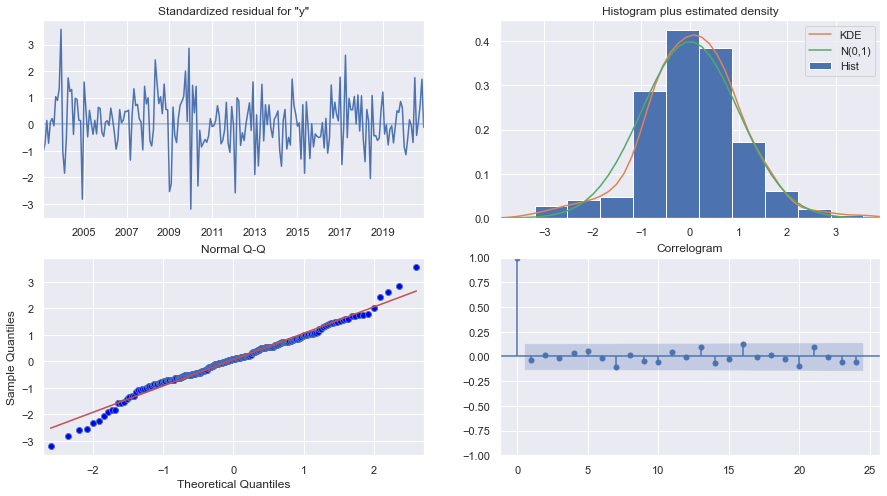

In [72]:
ax = res_arima1.plot_diagnostics(lags=24)

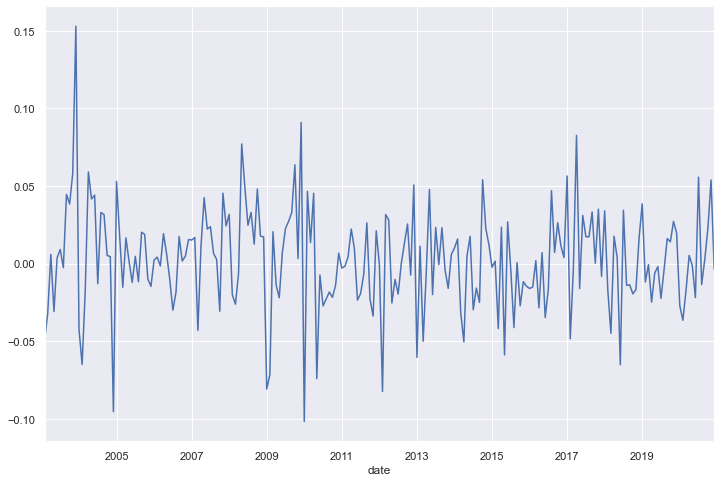

In [73]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

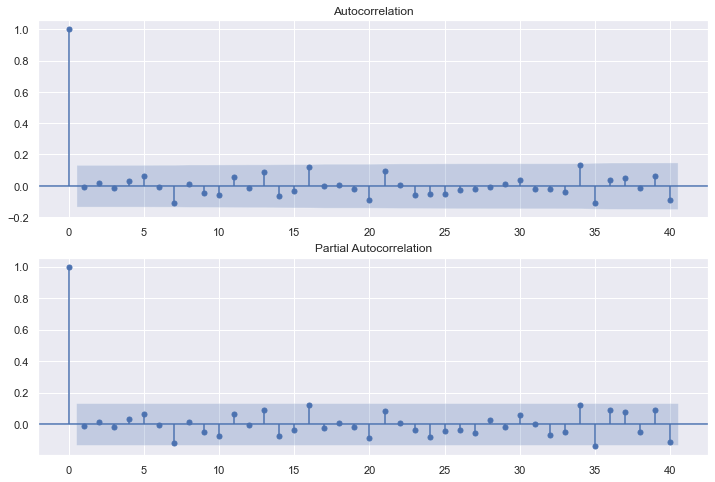

In [74]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

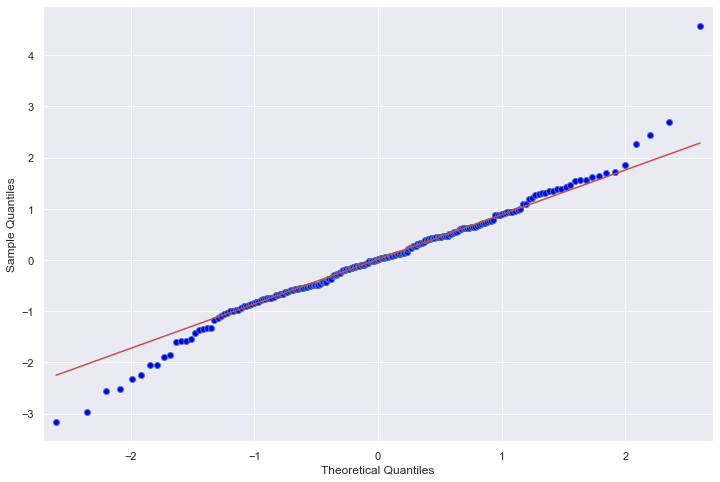

In [75]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [76]:
previsoes['nome'].append('SARIMAX(1,1,1)(2,0,1)')
previsoes['modelo'].append(res_arima1)

In [77]:
y_arima1_pred = np.exp(res_arima1.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima1_pred)
y_arima1_pred

2021-01-01    1.467361e+10
2021-02-01    1.375463e+10
2021-03-01    1.414009e+10
2021-04-01    1.431982e+10
2021-05-01    1.407097e+10
2021-06-01    1.386741e+10
2021-07-01    1.459660e+10
2021-08-01    1.439260e+10
2021-09-01    1.465291e+10
2021-10-01    1.488390e+10
2021-11-01    1.533942e+10
2021-12-01    1.581741e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [78]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

1374821958.554816

In [79]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.06935940263086865

In [80]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

#### Previsões com Exógenas Reais

In [81]:
previsoes['nome'].append('SARIMAX(1,1,1),(2,0,1) Real')
previsoes['modelo'].append(None)

In [82]:
y_arima3_pred = np.exp(res_arima1.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima3_pred)
y_arima3_pred

2021-01-01    1.497624e+10
2021-02-01    1.436615e+10
2021-03-01    1.526673e+10
2021-04-01    1.557854e+10
2021-05-01    1.566451e+10
2021-06-01    1.536424e+10
2021-07-01    1.625772e+10
2021-08-01    1.610536e+10
2021-09-01    1.628286e+10
2021-10-01    1.656879e+10
2021-11-01    1.714483e+10
2021-12-01    1.788242e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [83]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

846759348.3424369

In [84]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.04433703869760328

In [85]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelo critério de Schwartz

In [86]:
mod_arima2 = ARIMA(endog=icms_train, exog=exog_train, order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))
res_arima2 = mod_arima2.fit()
print(res_arima2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  216
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 429.337
Date:                          Tue, 09 May 2023   AIC                           -834.674
Time:                                  15:16:34   BIC                           -794.226
Sample:                              01-01-2003   HQIC                          -818.331
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0006      0.001      0.437      0.662      -0.002       0.003
x2             0.0008      0.000      2.621      0.

#### Análise dos Resíduos

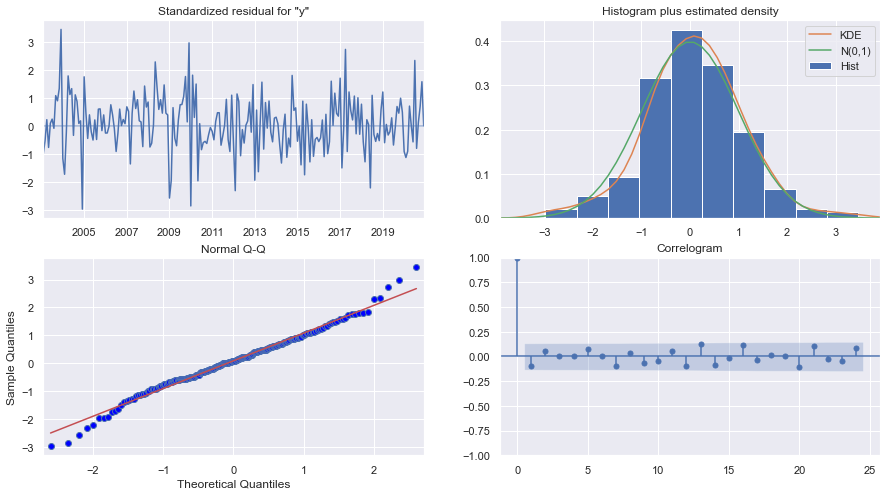

In [87]:
ax = res_arima2.plot_diagnostics(lags=24)

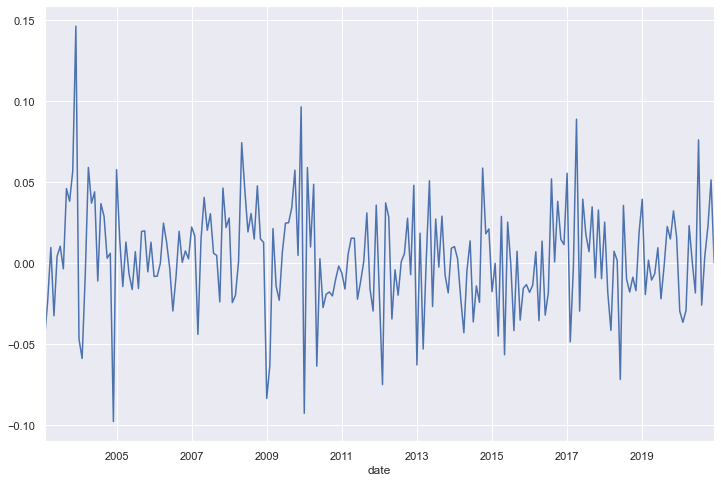

In [88]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima2.resid[1:].plot(ax=ax)

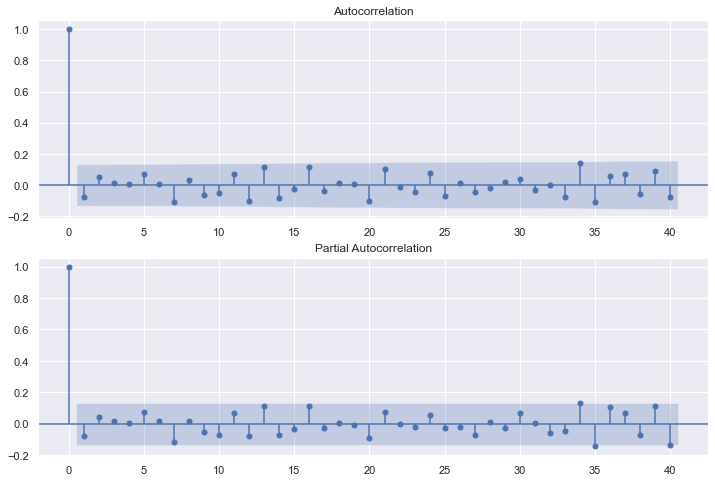

In [89]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima2.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima2.resid[1:], lags=40, ax=ax2)

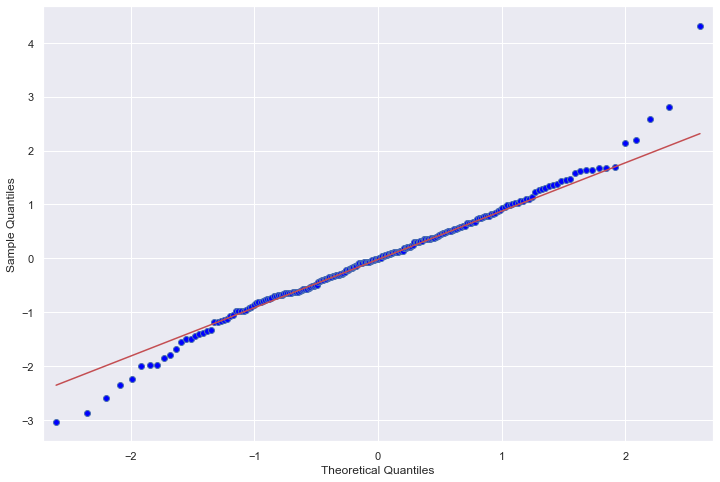

In [90]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima2.resid[1:], line="q", ax=ax, fit=True)

#### Previsões com Exógenas Previstas

In [91]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima2)

In [92]:
y_arima2_pred = np.exp(res_arima2.forecast(12, exog=exog_test))
previsoes['previsoes'].append(y_arima2_pred)
y_arima2_pred

2021-01-01    1.453074e+10
2021-02-01    1.369414e+10
2021-03-01    1.398896e+10
2021-04-01    1.435659e+10
2021-05-01    1.408488e+10
2021-06-01    1.390193e+10
2021-07-01    1.479638e+10
2021-08-01    1.438225e+10
2021-09-01    1.464777e+10
2021-10-01    1.485325e+10
2021-11-01    1.534610e+10
2021-12-01    1.580295e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [93]:
RMSE_arima2 = mean_squared_error(icms_test, y_arima2_pred, squared=False)
previsoes['rmse'].append(RMSE_arima2)
RMSE_arima2

1371730056.9490407

In [94]:
MAPE_arima2 = mean_absolute_percentage_error(icms_test, y_arima2_pred)
previsoes['mape'].append(MAPE_arima2)
MAPE_arima2

0.06824047823153967

In [95]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima2_pred, icms_test)])

#### Previsões com as Exógenas Reais

In [96]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1) Real')
previsoes['modelo'].append(None)

In [97]:
y_arima4_pred = np.exp(res_arima2.forecast(12, exog=exog_reais_test))
previsoes['previsoes'].append(y_arima4_pred)
y_arima4_pred

2021-01-01    1.483240e+10
2021-02-01    1.424812e+10
2021-03-01    1.499240e+10
2021-04-01    1.549444e+10
2021-05-01    1.551009e+10
2021-06-01    1.521739e+10
2021-07-01    1.632195e+10
2021-08-01    1.595820e+10
2021-09-01    1.615647e+10
2021-10-01    1.651835e+10
2021-11-01    1.707799e+10
2021-12-01    1.774959e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [98]:
RMSE_arima4 = mean_squared_error(icms_test, y_arima4_pred, squared=False)
previsoes['rmse'].append(RMSE_arima4)
RMSE_arima4

786953599.0877376

In [99]:
MAPE_arima4 = mean_absolute_percentage_error(icms_test, y_arima4_pred)
previsoes['mape'].append(MAPE_arima4)
MAPE_arima4

0.039945986226632965

In [100]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima4_pred, icms_test)])

### Comparação dos Modelos SARIMAX com Endógenas Previstas e Reais

In [101]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][0]: previsoes['previsoes'][0],
                                 previsoes['nome'][1]: previsoes['previsoes'][1],
                                 previsoes['nome'][2]: previsoes['previsoes'][2],
                                 previsoes['nome'][3]: previsoes['previsoes'][3]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMAX(1,1,1)(2,0,1)","SARIMAX(1,1,1),(2,0,1) Real","SARIMAX(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1) Real",real
2021-01-01,1.467361e+10,1.497624e+10,1.453074e+10,1.483240e+10,1.413347e+10
2021-02-01,1.375463e+10,1.436615e+10,1.369414e+10,1.424812e+10,1.370153e+10
2021-03-01,1.414009e+10,1.526673e+10,1.398896e+10,1.499240e+10,1.484308e+10
2021-04-01,1.431982e+10,1.557854e+10,1.435659e+10,1.549444e+10,1.366780e+10
2021-05-01,1.407097e+10,1.566451e+10,1.408488e+10,1.551009e+10,1.414623e+10
2021-06-01,1.386741e+10,1.536424e+10,1.390193e+10,1.521739e+10,1.465265e+10
2021-07-01,1.459660e+10,1.625772e+10,1.479638e+10,1.632195e+10,1.570838e+10
2021-08-01,1.439260e+10,1.610536e+10,1.438225e+10,1.595820e+10,1.597532e+10
2021-09-01,1.465291e+10,1.628286e+10,1.464777e+10,1.615647e+10,1.622460e+10
2021-10-01,1.488390e+10,1.656879e+10,1.485325e+10,1.651835e+10,1.664068e+10


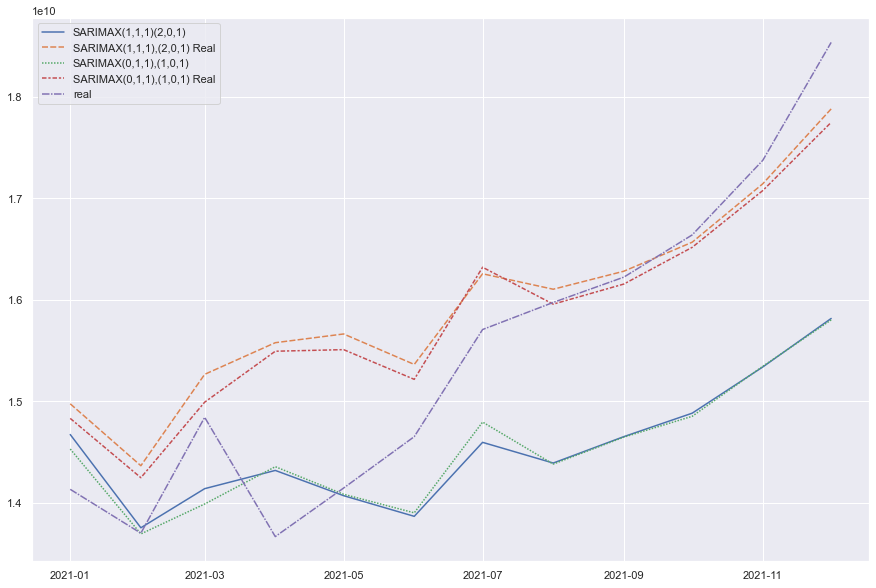

In [102]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

In [103]:
df_arima_rmse = pd.DataFrame(data=previsoes['rmse'][0:4], index= previsoes['nome'][0:4]).transpose()

In [104]:
df_arima_mape = pd.DataFrame(data=previsoes['mape'][0:4], index= previsoes['nome'][0:4]).transpose()

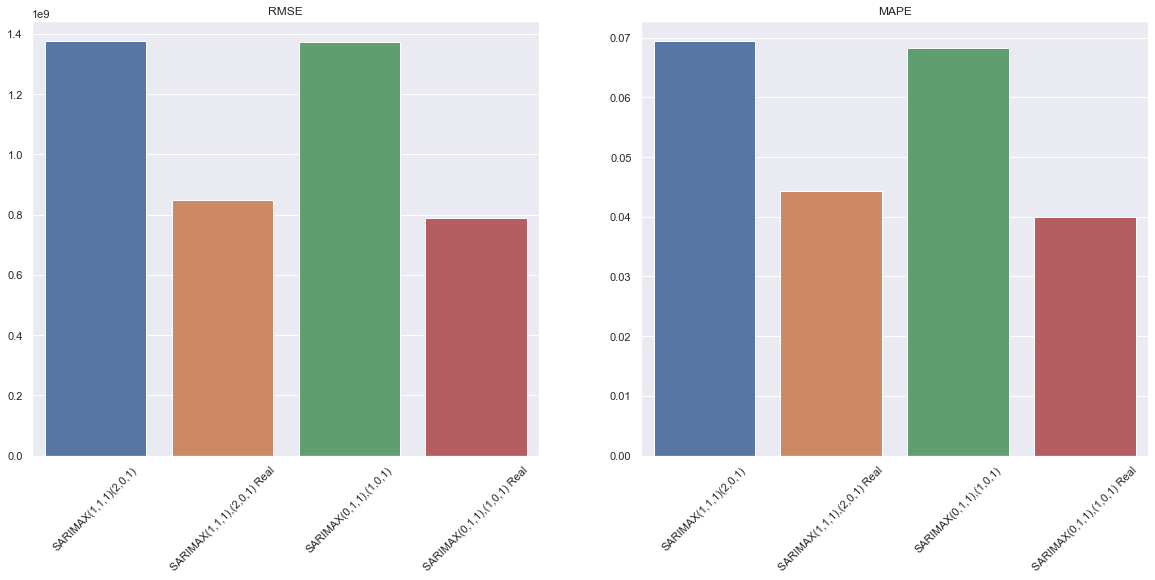

In [105]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_arima_rmse)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_arima_mape)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

## Modelo de Markov-Switching


A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em nível - Y
- constante - mudança de regime (*regime switching*)
- ibc-br real - (*regime switching*) 
- igp-m real - (*regime switching*) 
- dólar real - (*regime switching*) 
- dias úteis - X (variável)
- 11 dummies sazonais centradas - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*) - este modelo não convergiu.

In [106]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-24:-12]

### Modelo com Variância Fixa

In [107]:
arq1 = open('./ox/21_results_multi_fixed.txt', 'r')
print(arq1.read())
arq1.close()

variaveis_previsao.xlsx saved to /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at  0:42:27 on 24-04-2023 ----

Switching( 1) Modelling Licms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-01-01 - 2020-12-01
(3263): CovarMSAR

                Coefficient   Std.Error  t-value  t-prob
dias_uteis      -0.00117592    0.004173   -0.282   0.778
CSeasonal        -0.0176751     0.01204    -1.47   0.144
CSeasonal_1      -0.0828011     0.01410    -5.87   0.000
CSeasonal_2       -0.165924     0.01230    -13.5   0.000
CSeasonal_3      -0.0936775     0.01278    -7.33   0.000
CSeasonal_4       -0.110348     0.01208    -9.13   0.000
CSeasonal_5      -0.0985435     0.01223    -8.05   0.000
CSeasonal_6       -0.142436     0.01222    

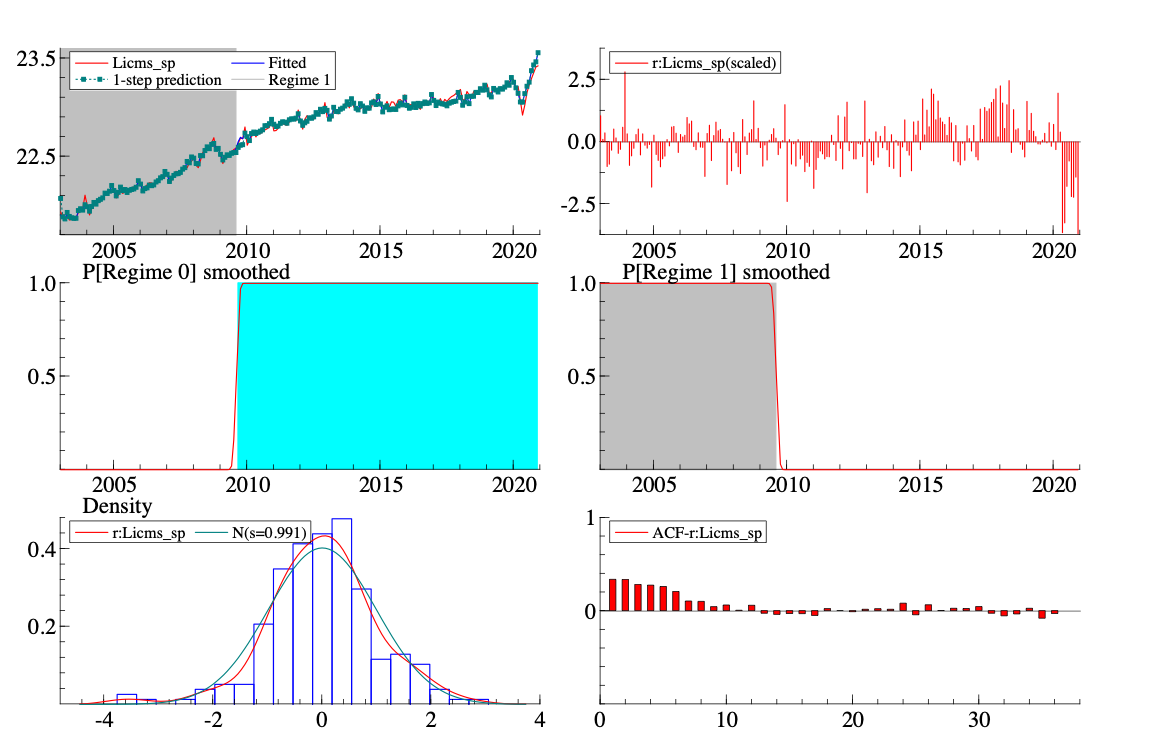

#### Previsões

In [108]:
y_markov_fixed_pred = np.exp(markov_forecast_df['21_forecast_multi_fixed'])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2021-01-01    1.599569e+10
2021-02-01    1.596411e+10
2021-03-01    1.685430e+10
2021-04-01    1.758422e+10
2021-05-01    1.795812e+10
2021-06-01    1.834757e+10
2021-07-01    1.865980e+10
2021-08-01    1.885964e+10
2021-09-01    1.915132e+10
2021-10-01    1.911888e+10
2021-11-01    1.961859e+10
2021-12-01    2.170476e+10
Name: 21_forecast_multi_fixed, dtype: float64

In [109]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [110]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

2929019971.743074

In [111]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.1865180922544849

In [112]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

### Modelo com mudança da Variância

In [113]:
arq2 = open('./ox/21_results_multi_var.txt', 'r')
print(arq2.read())
arq2.close()


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at  0:50:38 on 24-04-2023 ----

Switching( 1) Modelling Licms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-01-01 - 2020-12-01
(3263): CovarMSAR

                Coefficient   Std.Error  t-value  t-prob
dias_uteis      -0.00144462    0.002684   -0.538   0.591
CSeasonal       -0.00952937     0.01115   -0.855   0.394
CSeasonal_1      -0.0838662     0.01296    -6.47   0.000
CSeasonal_2       -0.169049     0.01111    -15.2   0.000
CSeasonal_3      -0.0973066     0.01176    -8.27   0.000
CSeasonal_4       -0.105404     0.01107    -9.52   0.000
CSeasonal_5      -0.0931720     0.01121    -8.32   0.000
CSeasonal_6       -0.139483     0.01134    -12.3   0.000
CSeasonal_7       -0.127363     0.01155    -11.0   0.000
CSeasonal_8      -0.0724485     0.01149    -6

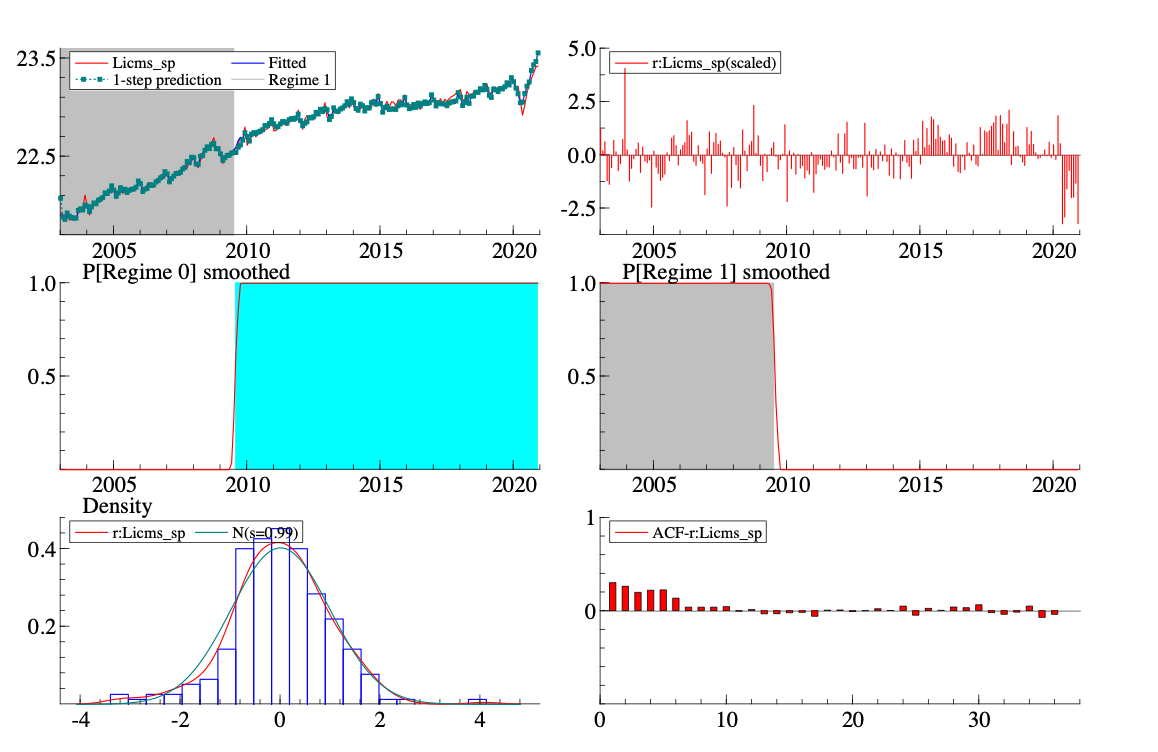

#### Previsões

In [114]:
y_markov_switching_pred = np.exp(markov_forecast_df['21_forecast_multi_var'])
y_markov_switching_pred.index = icms_test.index
y_markov_switching_pred

date
2021-01-01    1.609698e+10
2021-02-01    1.593085e+10
2021-03-01    1.679467e+10
2021-04-01    1.751419e+10
2021-05-01    1.803421e+10
2021-06-01    1.843402e+10
2021-07-01    1.871234e+10
2021-08-01    1.892095e+10
2021-09-01    1.922014e+10
2021-10-01    1.914767e+10
2021-11-01    1.969687e+10
2021-12-01    2.169306e+10
Name: 21_forecast_multi_var, dtype: float64

In [115]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred)

In [116]:
RMSE_markov_switching = mean_squared_error(icms_test, y_markov_switching_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_switching)
RMSE_markov_switching

2960079415.990624

In [117]:
MAPE_markov_switching = mean_absolute_percentage_error(icms_test, y_markov_switching_pred)
previsoes['mape'].append(MAPE_markov_switching)
MAPE_markov_switching

0.18851007079532858

In [118]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred, icms_test)])

### Componente Média-Variância

In [119]:
arq3 = open('./ox/21_results_multi_mean_var.txt', 'r')
print(arq3.read())
arq3.close()


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at  0:53:21 on 24-04-2023 ----

Switching( 0) Modelling Licms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-01-01 - 2020-12-01

*** Warning: there was no convergence; log-likelihood     434.733461
parameter values:
   -0.0014398
    -0.024860
    -0.090633
     -0.17330
     -0.10106
     -0.10886
    -0.098130
     -0.14406
     -0.13581
    -0.079964
    -0.083818
    -0.077937
       20.875
       19.963
    0.0012718
    0.0033160
     0.025073
    0.0057357
    0.0096621
    0.0099450
      0.13585
     0.028930
      0.98756
       1.0000
      0.99520
SQPF using numerical derivatives (eps1=0.0001; eps2=0.005):
No convergence (no improvement in line search)
Used starting values:
   -0.0015435    -0.018349    -0.085216     -0.16885  

O modelo não convergiu.

#### Resultados dos Modelos de Markov

In [120]:
previsoes['nome']

['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(1,1,1),(2,0,1) Real',
 'SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Fixed',
 'Markov-Switching-Var']

In [121]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][4]: previsoes['previsoes'][4],
                                    previsoes['nome'][5]: previsoes['previsoes'][5]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

,Markov-Fixed,Markov-Switching-Var,real
date,,,
2021-01-01,1.599569e+10,1.609698e+10,1.413347e+10
2021-02-01,1.596411e+10,1.593085e+10,1.370153e+10
2021-03-01,1.685430e+10,1.679467e+10,1.484308e+10
2021-04-01,1.758422e+10,1.751419e+10,1.366780e+10
2021-05-01,1.795812e+10,1.803421e+10,1.414623e+10
2021-06-01,1.834757e+10,1.843402e+10,1.465265e+10
2021-07-01,1.865980e+10,1.871234e+10,1.570838e+10
2021-08-01,1.885964e+10,1.892095e+10,1.597532e+10
2021-09-01,1.915132e+10,1.922014e+10,1.622460e+10


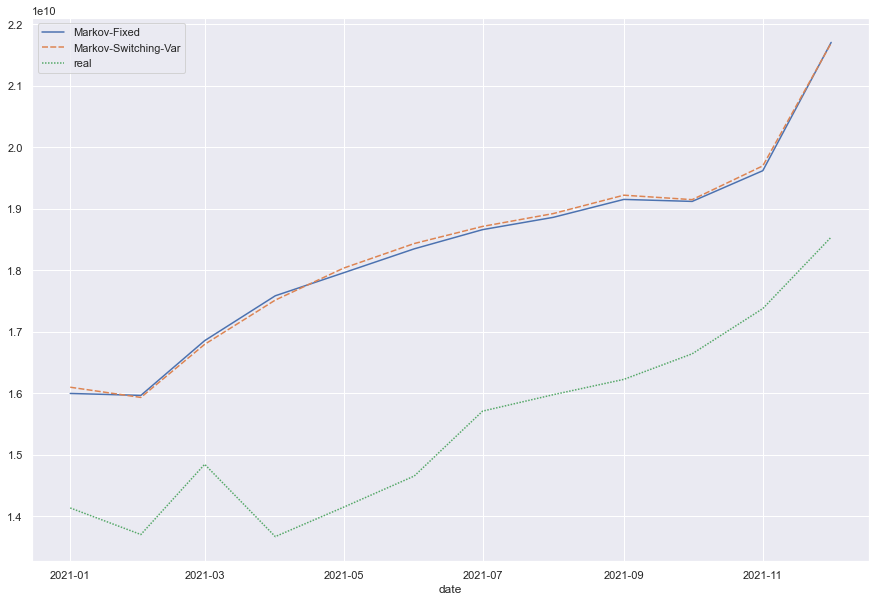

In [122]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série com as Variáveis Exógenas Previstas.
As redes neurais precisam de conjuntos de características e de etiquetas separados. As variáveis exógenas serão o conjunto de características e a variável endógena será o conjunto de etiquetas.

In [123]:
X_data = np.append(exog[:,:4], np.roll(exog[:,:4], 1, axis = 0), axis = 1)
X_data = np.append(X_data, np.roll(exog[:,:4], 2, axis = 0), axis = 1)[2:]
Y_data = icms_ts[2:].to_numpy()

In [124]:
X_data.shape, Y_data.shape

((226, 12), (226,))

### Montagem da Série com as Variáveis Exógenas Reais

In [125]:
X_reais_data = np.append(exog_reais[:,:4], np.roll(exog_reais[:,:4], 1, axis = 0), axis = 1)
X_reais_data = np.append(X_reais_data, np.roll(exog_reais[:,:4], 2, axis = 0), axis = 1)[2:]

In [126]:
X_reais_data.shape

(226, 12)

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [127]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
Y_train = Y_data[:-24]
Y_val = Y_data[-24:-12]
Y_test = np.exp(Y_data[-12:]) # tirando o log
print(Y_train.shape, Y_val.shape, Y_test.shape)

(202, 12) (12, 12) (12, 12)
(202,) (12,) (12,)


In [128]:
X_reais_test = X_reais_data[-12:]
print(X_reais_test.shape)

(12, 12)


In [129]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(X_train.shape[1]))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)
X_reais_test_std = enc_x.transform(X_reais_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)
print(X_reais_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(202, 12)
(12, 12)
(12, 12)
(12, 12)


In [133]:
x_train = X_train_std#.reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
x_val = X_val_std#.reshape(X_val_std.shape[0], X_val_std.shape[1], 1)
x_test = X_test_std#.reshape(X_test_std.shape[0], X_test_std.shape[1], 1)
x_reais_test = X_reais_test_std#.reshape(X_reais_test_std.shape[0], X_reais_test_std.shape[1], 1)
print(x_train.shape, x_val.shape, x_test.shape, x_reais_test.shape)

y_train = Y_train#.reshape(Y_train.shape[0], 1)
y_val = Y_val#.reshape(Y_val.shape[0], 1)
y_test = Y_test#.reshape(Y_test.shape[0], 1)
print(y_train.shape, y_val.shape, y_test.shape)

(202, 12) (12, 12) (12, 12) (12, 12)
(202,) (12,) (12,)


### Criando o modelo de Random Forests

In [131]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

#### Arquitetura da Rede

In [182]:
# Épocas
N_ESTIMATORS = 5000
MAX_DEPTH = None

# Imstanciação do modelo
model = RandomForestRegressor(n_estimators = N_ESTIMATORS, max_depth = MAX_DEPTH)

model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=5000)

In [183]:
y_val_pred = model.predict(x_val)

In [184]:
prev_rf_val_df = pd.DataFrame(data={'predito': np.exp(y_val_pred),
                                    'real': np.exp(y_val)
                                   })
prev_rf_val_df

,predito,real
0,1.259784e+10,1.292981e+10
1,1.260308e+10,1.177686e+10
2,1.270722e+10,1.208593e+10
3,1.195306e+10,1.045560e+10
4,1.096091e+10,9.023529e+09
5,9.531408e+09,9.983544e+09
6,1.029320e+10,1.134873e+10
7,1.163741e+10,1.227731e+10
8,1.272890e+10,1.309835e+10
9,1.266588e+10,1.387787e+10


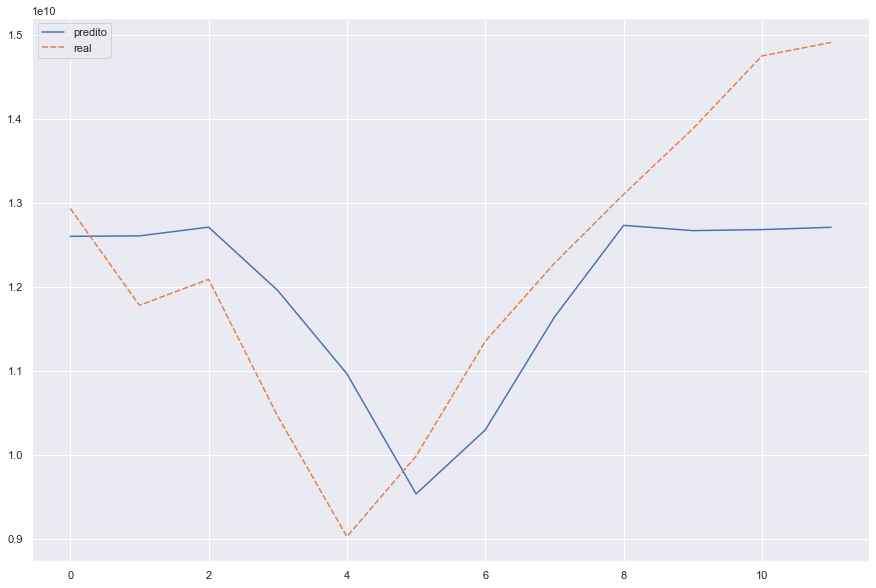

In [185]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_rf_val_df)

### Previsão 12 meses em Teste com Exógenas Previstas

In [186]:
Y_pred1 = np.exp(model.predict(x_test))
Y_pred1

array([1.26721285e+10, 1.25209753e+10, 1.25378482e+10, 1.26836262e+10,
       1.27141598e+10, 1.25704086e+10, 1.25690740e+10, 1.26329032e+10,
       1.26540634e+10, 1.26562036e+10, 1.26706362e+10, 1.27058931e+10])

In [187]:
y_pred1 = pd.Series(Y_pred1.ravel())
y_pred1.index = icms_ts.index[-12:]
y_pred1

date
2021-01-01    1.267213e+10
2021-02-01    1.252098e+10
2021-03-01    1.253785e+10
2021-04-01    1.268363e+10
2021-05-01    1.271416e+10
2021-06-01    1.257041e+10
2021-07-01    1.256907e+10
2021-08-01    1.263290e+10
2021-09-01    1.265406e+10
2021-10-01    1.265620e+10
2021-11-01    1.267064e+10
2021-12-01    1.270589e+10
dtype: float64

In [188]:
RMSE_lstm1 = mean_squared_error(y_test, y_pred1, squared=False)
RMSE_lstm1

3188537785.5661263

In [189]:
MAPE_lstm1 = mean_absolute_percentage_error(y_test, y_pred1)
MAPE_lstm1

0.17618227837566033

In [190]:
previsoes['nome'].append('RNN-LSTM')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(y_pred1)

previsoes['rmse'].append(RMSE_lstm1)

previsoes['mape'].append(MAPE_lstm1)

In [191]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred1, y_test)])

### Previsão 12 meses em Teste com Exógenas Reais

In [192]:
Y_pred2 = np.exp(model.predict(x_reais_test))
Y_pred2

array([1.26703984e+10, 1.25235824e+10, 1.26415002e+10, 1.26328806e+10,
       1.27956780e+10, 1.26921180e+10, 1.26656832e+10, 1.26381420e+10,
       1.26864311e+10, 1.27132628e+10, 1.26883421e+10, 1.26858146e+10])

In [193]:
y_pred2 = pd.Series(Y_pred2.ravel())
y_pred2.index = icms_ts.index[-12:]
y_pred2

date
2021-01-01    1.267040e+10
2021-02-01    1.252358e+10
2021-03-01    1.264150e+10
2021-04-01    1.263288e+10
2021-05-01    1.279568e+10
2021-06-01    1.269212e+10
2021-07-01    1.266568e+10
2021-08-01    1.263814e+10
2021-09-01    1.268643e+10
2021-10-01    1.271326e+10
2021-11-01    1.268834e+10
2021-12-01    1.268581e+10
dtype: float64

In [194]:
RMSE_lstm2 = mean_squared_error(y_test, y_pred2, squared=False)
RMSE_lstm2

3157941571.174462

In [195]:
MAPE_lstm2 = mean_absolute_percentage_error(y_test, y_pred2)
MAPE_lstm2

0.17374519835043292

In [196]:
previsoes['nome'].append('RNN-LSTM-Real')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_pred2)

previsoes['rmse'].append(RMSE_lstm2)

previsoes['mape'].append(MAPE_lstm2)

In [197]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred2, y_test)])

## Resultados

In [198]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [199]:
df_prev

,"SARIMAX(1,1,1)(2,0,1)","SARIMAX(1,1,1),(2,0,1) Real","SARIMAX(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1) Real",Markov-Fixed,Markov-Switching-Var,RNN-LSTM,RNN-LSTM-Real,RNN-LSTM,RNN-LSTM-Real,RNN-LSTM,RNN-LSTM-Real,real
2021-01-01,1.467361e+10,1.497624e+10,1.453074e+10,1.483240e+10,1.599569e+10,1.609698e+10,1.258439e+10,1.258439e+10,1.266159e+10,1.266159e+10,1.267213e+10,1.267040e+10,1.413347e+10
2021-02-01,1.375463e+10,1.436615e+10,1.369414e+10,1.424812e+10,1.596411e+10,1.593085e+10,1.244490e+10,1.254806e+10,1.250076e+10,1.251660e+10,1.252098e+10,1.252358e+10,1.370153e+10
2021-03-01,1.414009e+10,1.526673e+10,1.398896e+10,1.499240e+10,1.685430e+10,1.679467e+10,1.255747e+10,1.263734e+10,1.251874e+10,1.262325e+10,1.253785e+10,1.264150e+10,1.484308e+10
2021-04-01,1.431982e+10,1.557854e+10,1.435659e+10,1.549444e+10,1.758422e+10,1.751419e+10,1.267530e+10,1.260418e+10,1.268220e+10,1.263570e+10,1.268363e+10,1.263288e+10,1.366780e+10
2021-05-01,1.407097e+10,1.566451e+10,1.408488e+10,1.551009e+10,1.795812e+10,1.803421e+10,1.272459e+10,1.277831e+10,1.270901e+10,1.280157e+10,1.271416e+10,1.279568e+10,1.414623e+10
2021-06-01,1.386741e+10,1.536424e+10,1.390193e+10,1.521739e+10,1.834757e+10,1.843402e+10,1.260446e+10,1.271707e+10,1.255544e+10,1.269450e+10,1.257041e+10,1.269212e+10,1.465265e+10
2021-07-01,1.459660e+10,1.625772e+10,1.479638e+10,1.632195e+10,1.865980e+10,1.871234e+10,1.258102e+10,1.269138e+10,1.254860e+10,1.266499e+10,1.256907e+10,1.266568e+10,1.570838e+10
2021-08-01,1.439260e+10,1.610536e+10,1.438225e+10,1.595820e+10,1.885964e+10,1.892095e+10,1.260679e+10,1.261988e+10,1.263457e+10,1.264031e+10,1.263290e+10,1.263814e+10,1.597532e+10
2021-09-01,1.465291e+10,1.628286e+10,1.464777e+10,1.615647e+10,1.915132e+10,1.922014e+10,1.262174e+10,1.265230e+10,1.265773e+10,1.269284e+10,1.265406e+10,1.268643e+10,1.622460e+10
2021-10-01,1.488390e+10,1.656879e+10,1.485325e+10,1.651835e+10,1.911888e+10,1.914767e+10,1.268046e+10,1.272300e+10,1.265540e+10,1.271220e+10,1.265620e+10,1.271326e+10,1.664068e+10


In [154]:
df_erro

,"SARIMAX(1,1,1)(2,0,1)","SARIMAX(1,1,1),(2,0,1) Real","SARIMAX(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1) Real",Markov-Fixed,Markov-Switching-Var,RNN-LSTM,RNN-LSTM-Real
0,3.821668,5.962928,2.810796,4.945162,13.175945,13.892574,10.960379,10.960379
1,0.387543,4.850722,0.053931,3.989242,16.513351,16.270598,9.171482,8.418550
2,4.736140,2.854176,5.754332,1.005977,13.549867,13.148106,15.398480,14.860449
3,4.770470,13.979818,5.039487,13.364557,28.654332,28.141961,7.261637,7.781962
4,0.531953,10.732775,0.433687,9.641181,26.946396,27.484229,10.049584,9.669807
5,5.359045,4.856345,5.123489,3.854140,25.216712,25.806680,13.978341,13.209790
6,7.077626,3.497129,5.805801,3.905979,18.788816,19.123292,19.908868,19.206298
7,9.907306,0.813976,9.972094,0.107180,18.054847,18.438620,21.085862,21.003927
8,9.687070,0.359055,9.718778,0.419936,18.038740,18.462928,22.206200,22.017841
9,10.557141,0.432000,10.741336,0.735096,14.892404,15.065405,23.798436,23.542770


### Resultados Apenas das Redes Neurais

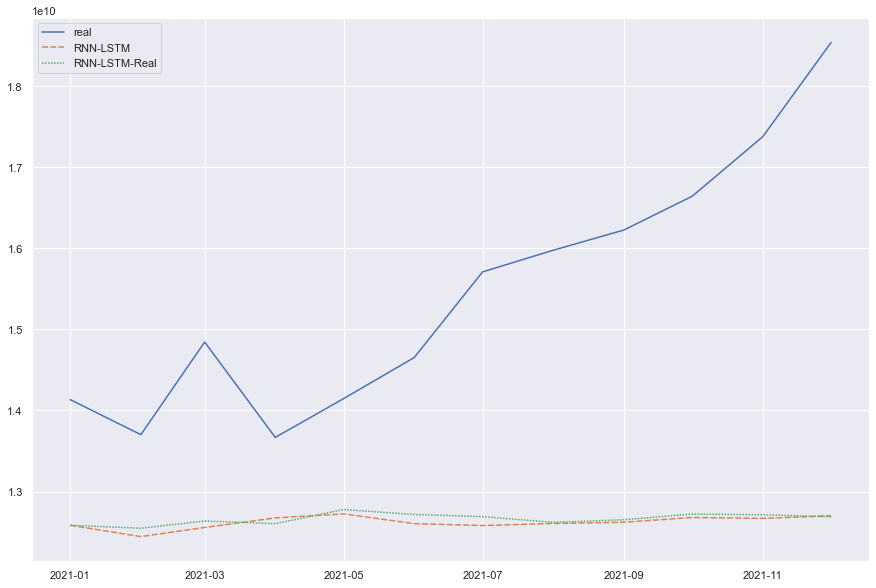

In [155]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM', 'RNN-LSTM-Real']])

In [156]:
df_rmse_lstm = df_rmse[['RNN-LSTM', 'RNN-LSTM-Real']]
df_mape_lstm = df_mape[['RNN-LSTM', 'RNN-LSTM-Real']]

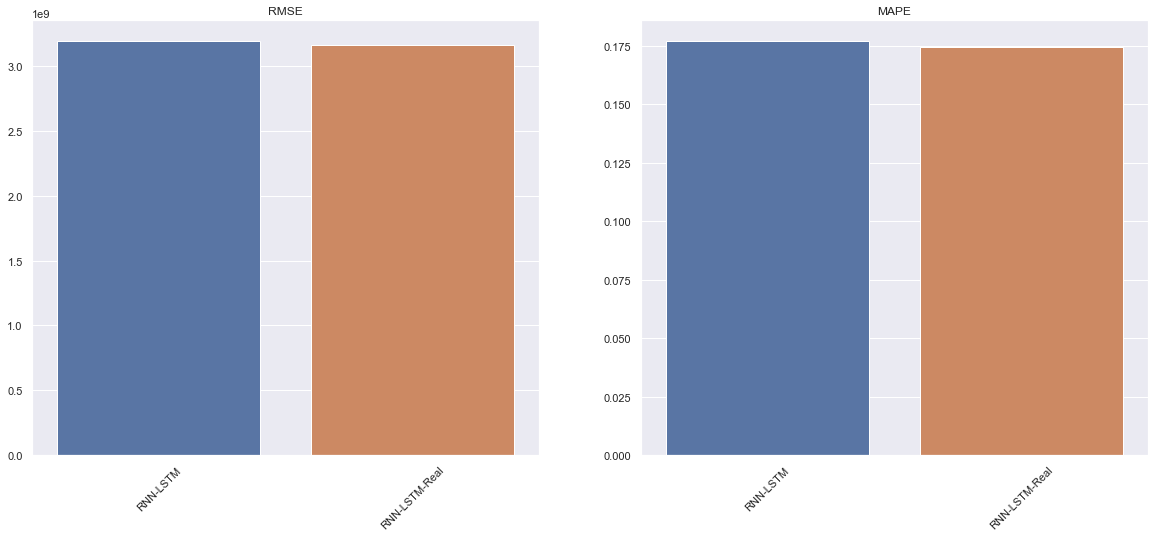

In [157]:
fig=plt.figure(figsize=(20, 8))
ax1=fig.add_subplot(121)
ax1 = sns.barplot(data=df_rmse_lstm)
ax1.set_title('RMSE')
_ = plt.xticks(rotation=45)
ax2=fig.add_subplot(122)
ax2 = sns.barplot(data=df_mape_lstm)
ax2.set_title('MAPE')
_ = plt.xticks(rotation=45)
plt.show()

### Resultados Gerais com os Dados Previstos

#### Previsões com os Dados Previstos

In [158]:
df_prev_prev = df_prev[['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'RNN-LSTM', 'real']]

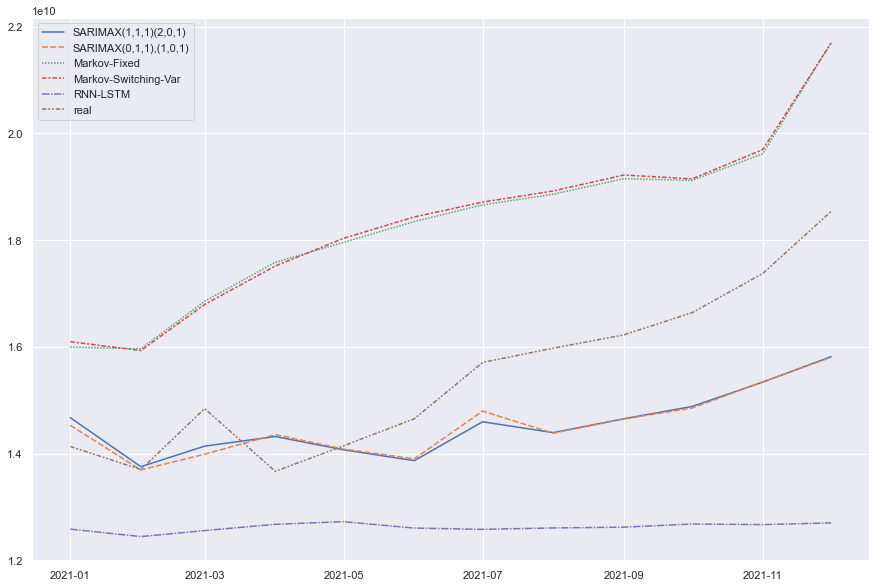

In [159]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev_prev)

#### RMSE com Dados Previstos

In [160]:
previsoes['nome']

['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(1,1,1),(2,0,1) Real',
 'SARIMAX(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1) Real',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'RNN-LSTM',
 'RNN-LSTM-Real']

In [161]:
df_rmse

,"SARIMAX(1,1,1)(2,0,1)","SARIMAX(1,1,1),(2,0,1) Real","SARIMAX(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1) Real",Markov-Fixed,Markov-Switching-Var,RNN-LSTM,RNN-LSTM-Real
0,1.374822e+09,8.467593e+08,1.371730e+09,7.869536e+08,2.929020e+09,2.960079e+09,3.193806e+09,3.158949e+09


In [162]:
df_rmse_prev = df_rmse[['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'RNN-LSTM']]

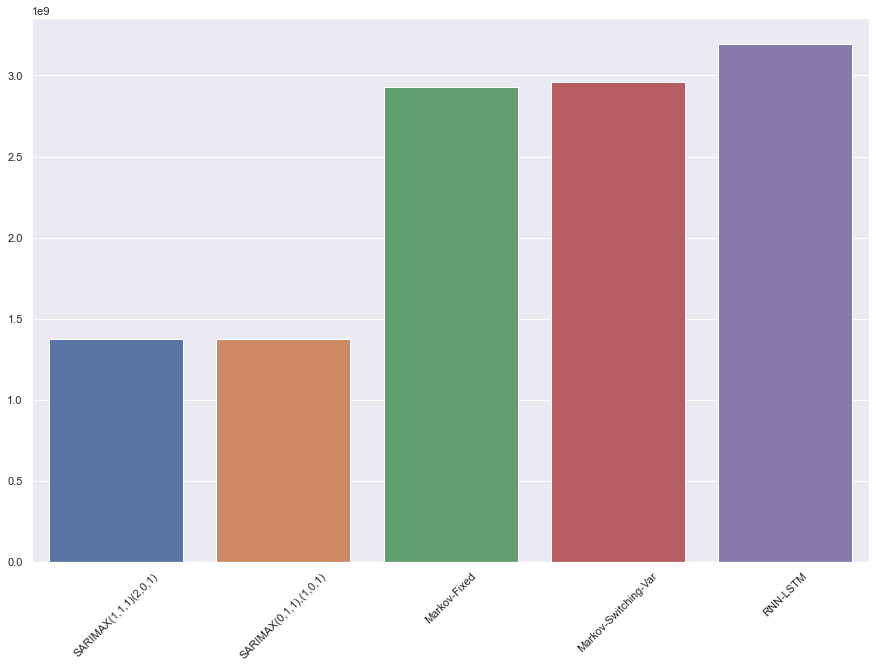

In [163]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_rmse_prev)
_ = plt.xticks(rotation=45)

#### MAPE dos Dados Previstos

In [164]:
df_mape_prev = df_mape[['SARIMAX(1,1,1)(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'RNN-LSTM']]

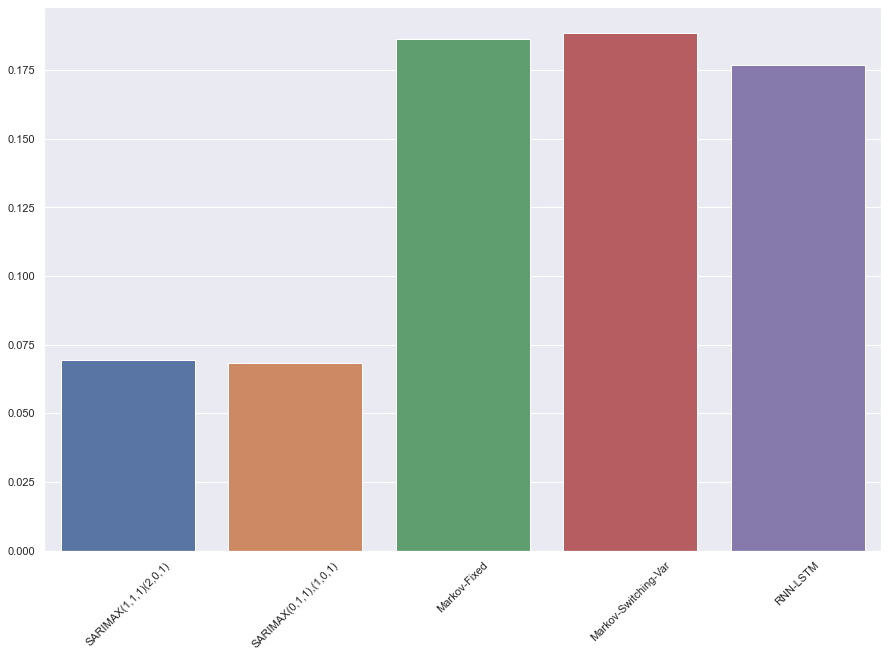

In [165]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_mape_prev)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [165]:
df_rmse_prev.index = ['RMSE']
df_mape_prev.index = ['MAPE']

In [166]:
df_metricas = df_rmse_prev.copy()
df_metricas = df_metricas.append(df_mape_prev)
df_metricas

,"SARIMAX(1,1,1)(2,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,RNN-LSTM
RMSE,1.374822e+09,1.371730e+09,2.929020e+09,2.960079e+09,2.323729e+09
MAPE,6.935940e-02,6.824048e-02,1.865181e-01,1.885101e-01,1.167525e-01


In [167]:
df_metricas.to_excel('./metricas_multi_2021.xlsx', index_label='metrica')

In [168]:
print(df_metricas.transpose().to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.374822e+09 &  0.069359 \\
SARIMAX(0,1,1),(1,0,1) &  1.371730e+09 &  0.068240 \\
Markov-Fixed           &  2.929020e+09 &  0.186518 \\
Markov-Switching-Var   &  2.960079e+09 &  0.188510 \\
RNN-LSTM               &  2.323729e+09 &  0.116752 \\
\bottomrule
\end{tabular}



In [169]:
print(df_prev_prev['2021-01-01':'2021-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2021-01-01 &    2021-02-01 &    2021-03-01 &    2021-04-01 \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.467361e+10 &  1.375463e+10 &  1.414009e+10 &  1.431982e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.453074e+10 &  1.369414e+10 &  1.398896e+10 &  1.435659e+10 \\
Markov-Fixed           &  1.599569e+10 &  1.596411e+10 &  1.685430e+10 &  1.758422e+10 \\
Markov-Switching-Var   &  1.609698e+10 &  1.593085e+10 &  1.679467e+10 &  1.751419e+10 \\
RNN-LSTM               &  1.327961e+10 &  1.312117e+10 &  1.382561e+10 &  1.342593e+10 \\
real                   &  1.413347e+10 &  1.370153e+10 &  1.484308e+10 &  1.366780e+10 \\
\bottomrule
\end{tabular}



In [170]:
print(df_prev_prev['2021-05-01':'2021-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2021-05-01 &    2021-06-01 &    2021-07-01 &    2021-08-01 \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.407097e+10 &  1.386741e+10 &  1.459660e+10 &  1.439260e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.408488e+10 &  1.390193e+10 &  1.479638e+10 &  1.438225e+10 \\
Markov-Fixed           &  1.795812e+10 &  1.834757e+10 &  1.865980e+10 &  1.885964e+10 \\
Markov-Switching-Var   &  1.803421e+10 &  1.843402e+10 &  1.871234e+10 &  1.892095e+10 \\
RNN-LSTM               &  1.334999e+10 &  1.348449e+10 &  1.374754e+10 &  1.375302e+10 \\
real                   &  1.414623e+10 &  1.465265e+10 &  1.570838e+10 &  1.597532e+10 \\
\bottomrule
\end{tabular}



In [171]:
print(df_prev_prev['2021-09-01':'2021-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2021-09-01 &    2021-10-01 &    2021-11-01 &    2021-12-01 \\
\midrule
SARIMAX(1,1,1)(2,0,1)  &  1.465291e+10 &  1.488390e+10 &  1.533942e+10 &  1.581741e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.464777e+10 &  1.485325e+10 &  1.534610e+10 &  1.580295e+10 \\
Markov-Fixed           &  1.915132e+10 &  1.911888e+10 &  1.961859e+10 &  2.170476e+10 \\
Markov-Switching-Var   &  1.922014e+10 &  1.914767e+10 &  1.969687e+10 &  2.169306e+10 \\
RNN-LSTM               &  1.353580e+10 &  1.363028e+10 &  1.366151e+10 &  1.387242e+10 \\
real                   &  1.622460e+10 &  1.664068e+10 &  1.737603e+10 &  1.853772e+10 \\
\bottomrule
\end{tabular}

